In [2]:
import numpy as np
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import behavior_plotting_fxns as pf
from pymer4.models import Lmer

%load_ext autoreload
%autoreload 2

SERVER_PATH = '/Volumes/shohamy-locker/shohamy_from_labshare/rgerraty/hybrid_mri/'
LOCAL_PATH = 'data/'

data = pd.read_csv(LOCAL_PATH + 'hybrid_data.csv')

# raw behavioral files:
# import scipy.io
# mat = scipy.io.loadmat(SERVER_PATH + 'behavior/02_output/Performance_1.mat')
# mat['Performance'][0,0][2]# [0][0]

# Data attributes

Data columns:

- ---------------- from original .mat files (some just in [CardGame.txt](https://github.com/rgerraty/rl_flexibility/blob/master/CardGame.txt) -----------------
- 'Sub': subject number (1-35 excluding subs 1, 3, 11, and 35)
- 'Run': run number (1-5)
- 'Trial': trial number (1-300)
- 'OldT': is one of the items old (0 or 1)
- 'Delay': how many trials since the old item was previously seen
- 'LuckyDeck': which deck is lucky on that trial (1 or 2)
- 'ObjPP': the value of the object when previously seen
- 'OldObjLuckyDeck': is the old object in the lucky deck? 1 for NO and 0 for YES (??) 
- 'ObjDeckMatch': on old trials, does the old card value match the luck of the deck it's in? (0 for YES, 1 for no ??) 
- 'Outcome': what reward did they get
- 'Resp': which side of the screen they selected (decks swapped randomly)
- 'RT': response time (ms)
- 'DeckC': deck chosen (1 = blue, 2 = red)
- 'LuckyDeckC': was lucky deck chosen (0 or 1)
- 'OldObjC': was the old object chosen when seen again (0 or 1 or nan)
- 'RevT': number of trials that the current lucky deck has been lucky (1 at the reversal)
- 'OldDeckPP': most recent outcome from the deck currently with the old card
- 'OldDeck': which deck the old item appears in
- 'EncRevT': RevT of the encoding trial
- 'Enc_Pay1': PP (prior payment) of the encoding trial
- 'OptObj': given an old object, did subject make the optimal choice? (i.e., was old value > 0.5), 0 or 1
- 'PP': most recent outcome from previous trial (prior pay)
- 'StayResp': current trial chosen deck (DeckC) is same as the last

--------------------------------- from [hybrid_data_stan.R](https://github.com/rgerraty/hybrid_reinforcement_learning/blob/master/hybrid_data_stan.R)  ---------------------------------

- 'DeckUnC': which deck was unchosen (1 or 2)
- 'ObjPP_C': centered outcome (ObjPP-0.5) but only if the old object is chosen (OldObjC)
- 'ChooseRed': was DeckC red (0 or 1)
- 'LuckRed': 0.5 is red is lucky, -0.5 if blue is lucky
- 'OldRed': 0.5 if old is red deck, -0.5 if old is blue deck, 0 if no old
- 'OldValRed': old-weighted red value: OldRed * zero-centered ObjPP (ObjPP - 0.5), 0 if no old
- 'pre_post_rev': in first half or second half of chunk between reversals (-0.5 or 0.5, median split of RevT)
- 'pre_post_rev_enc': same as above but for the old object when it was first seen, median split of EncRevT

--------------------------------- from [extract_rl_pars.R](https://github.com/rgerraty/hybrid_reinforcement_learning/blob/master/extract_RL_pars.R)  ----------------------------------

- 'Q_chosen_norm': column norm of Q_chosen
- 'Q_unchosen_norm': column norm of Q_unchosen
- 'Q_diff_norm': difference of above
- 'PE_norm': column norm of PE
- 'Q_chosen': Q value of chosen deck
- 'Q_unchosen': Q value of unchosen deck
- 'Q_diff': difference of above Q values
- 'Q_red': Q value of red deck (same as above)
- 'Q_blue': Q value of blue deck (same as above)
- 'PE': prediction error
- 'Inc_lik': (log) likelihood of incremental model
- 'Ep_lik': (log) likelihood of episodic model
- 'Inc_lik_norm': column norm of above (within subject)
- 'Ep_lik_norm': column norm of above (within subject)
- 'Lik_rat': ratio of the two (Inc_lik_norm - Ep_lik_norm) - subtracted because they are log likelihoods
- 'Ep_lik_enc': episodic likelihood (of the retrieval trial) shifted onto the encoding trial
- 'Ep_lik_norm_enc': column norm of above
- 'encT': trials on which old objects were first seen
- 'Lik_rat_norm': column norm of Lik_rat (within subject)

In [77]:
# def add_encoding_trial_to_beh(beh):
#     beh['encTrialNum'] = None
#     # Set encTrialNum for rows where 'OldT' == 1
#     for i, row in beh.iterrows():
#         if row['OldT'] == 1:
#             delay = row['Delay']
#             if i >= delay:
#                 beh.at[i, 'encTrialNum'] = beh.at[i - delay, 'Trial']
#     return beh
# beh = pd.read_csv('./data/hybrid_data.csv')
# beh = add_encoding_trial_to_beh(beh)
# beh.to_csv('./data/hybrid_data.csv',index=False)

# Behavioral analyses

### Paper figures

In [2]:
# add attributes
data['Switch_nexttrial'] = (~data.StayResp.astype(bool)).astype(int).shift(-1)
new_columns = [
    "Outcome_enc","Q_chosen_enc", "PE_enc", "PE_enc_unsigned", "PE_enc_sign",
    "PE_prevtrial_enc", "PE_prevtrial_enc_unsigned", "PE_prevtrial_enc_sign",
    "RT_enc","RevT_enc_centered"
]
for col in new_columns:
    data[col] = np.nan

for idx,row in data[data.OldT==1].iterrows():
    enc_idx = data[(data['Trial'] == row['encTrialNum']) & (data['Sub'] == row['Sub'])].index
    if len(enc_idx) == 0:
        continue
    enc_idx = enc_idx[0]

    data.at[idx, "Q_chosen_enc"] = data.at[enc_idx, "Q_chosen"]
    data.at[idx, "PE_enc"] = data.at[enc_idx, "PE"]
    if enc_idx != 0:
        data.at[idx, "PE_prevtrial_enc"] = data.at[enc_idx - 1, "PE"]
    data.at[idx, "RT_enc"] = np.log(data.at[enc_idx, "RT"])
    data.at[idx,'RevT_enc_centered'] = data.at[enc_idx,'RevT'] - 10

data['ObjPP_just1'] = float(row.ObjPP == 1) 
data['PE_enc_unsigned'] = data['PE_enc'].abs()
data['PE_enc_sign'] = np.sign(data['PE_enc'])
data['PE_prevtrial_enc_unsigned'] = data['PE_prevtrial_enc'].abs()
data['PE_prevtrial_enc_sign'] = np.sign(data['PE_prevtrial_enc'])

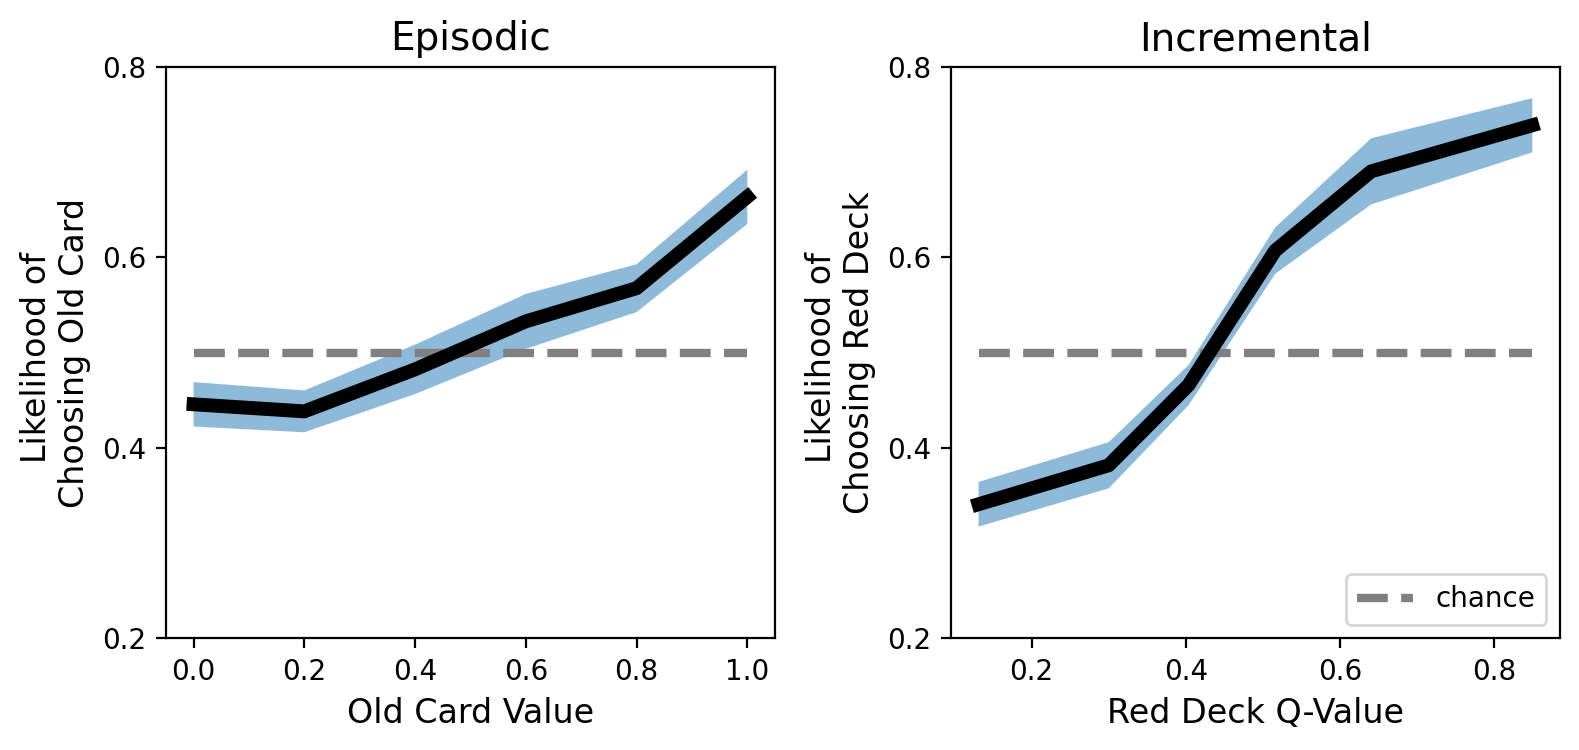

In [7]:
### MAIN

#### RAPHAEL'S INTERACTION PLOTS WERE ONLY COMPUTED IN R

pf.episodic_incremental(data, 
                        x_cols = ['ObjPP','Q_red'], 
                        y_cols = ['OldObjC','ChooseRed'],
                        x_texts = ["Old Card Value",'Red Deck Q-Value'], 
                        y_texts = ["Likelihood of \nChoosing Old Card", 'Likelihood of \nChoosing Red Deck'], 
                        subtitles=['Episodic','Incremental'], 
                        logistic_fit=False, shaded=True, ylim=(0.2,0.8))

# pf.episodic_incremental(data, 
#                         x_cols = ['Q_red','ObjPP'],  # 'RevT'
#                         y_cols = ['ChooseRed','OldObjC'], # 'LuckyDeckC'
#                         x_texts = ['Red Deck Q-Value',"Old Card Value"], # 'Trials Since Reversal'
#                         y_texts = [ 'Likelihood of Choosing Red Deck', "Likelihood of Choosing Old Card"], # 'Likelihood of Choosing Lucky Deck'
#                         subtitles=[ 'Incremental','Episodic'], # 'Reversal Learning'
#                         logistic_fit=False)

# pf.episodic_incremental(data, 
#                         x_cols = ['Q_red','ObjPP','RevT'],  # 
#                         y_cols = ['ChooseRed','OldObjC','LuckyDeckC'], # 
#                         x_texts = ['Red Deck Q-Value',"Old Card Value",'Trials Since Reversal'], # 
#                         y_texts = [ 'Likelihood of Choosing Red Deck', "Likelihood of Choosing Old Card", 'Likelihood of Choosing Lucky Deck'], #
#                         subtitles=[ 'Incremental','Episodic', 'Reversal Learning'], # 
#                         logistic_fit=False)

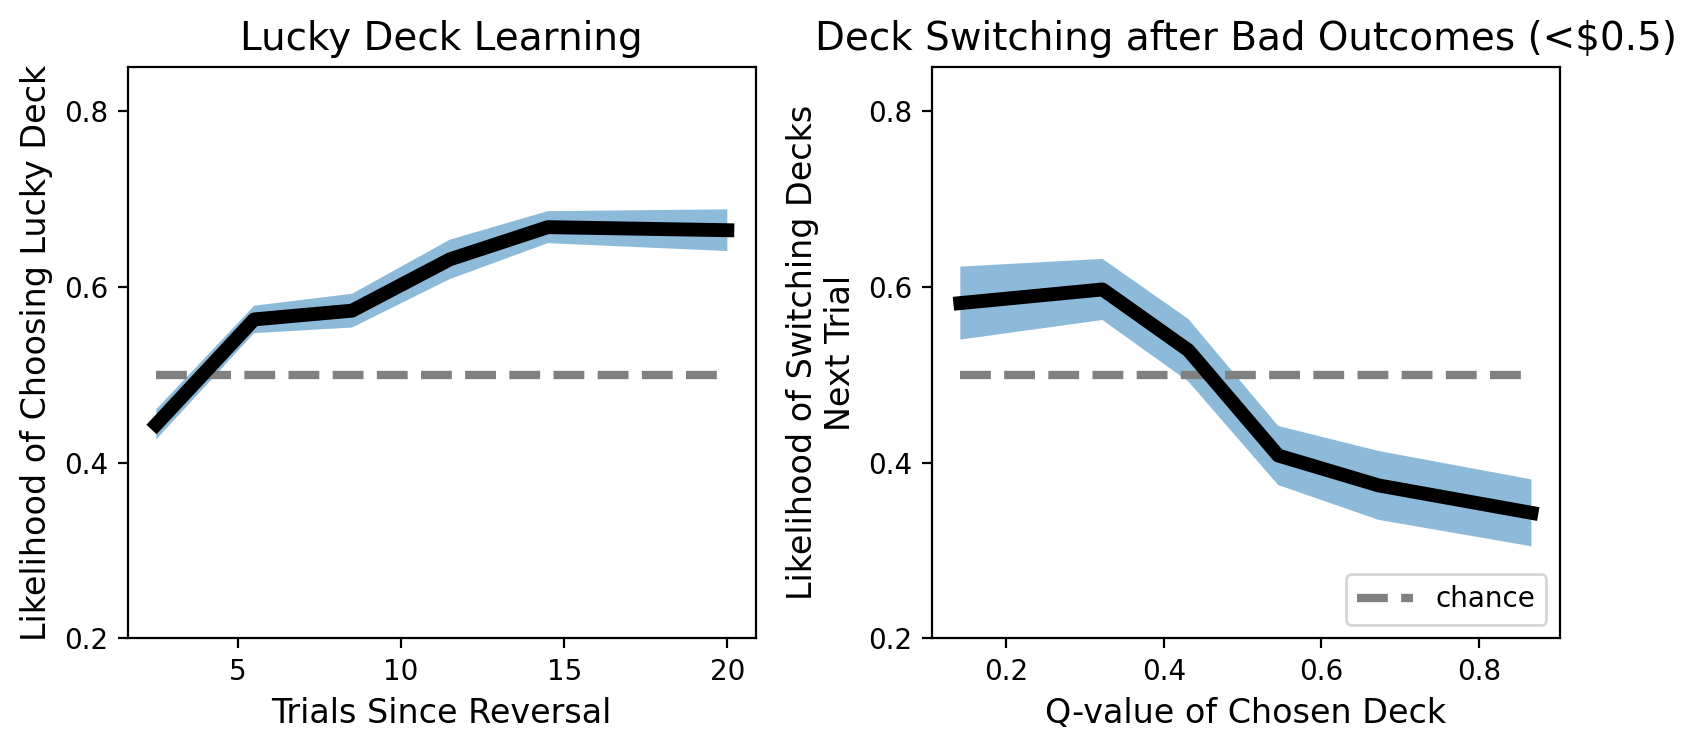

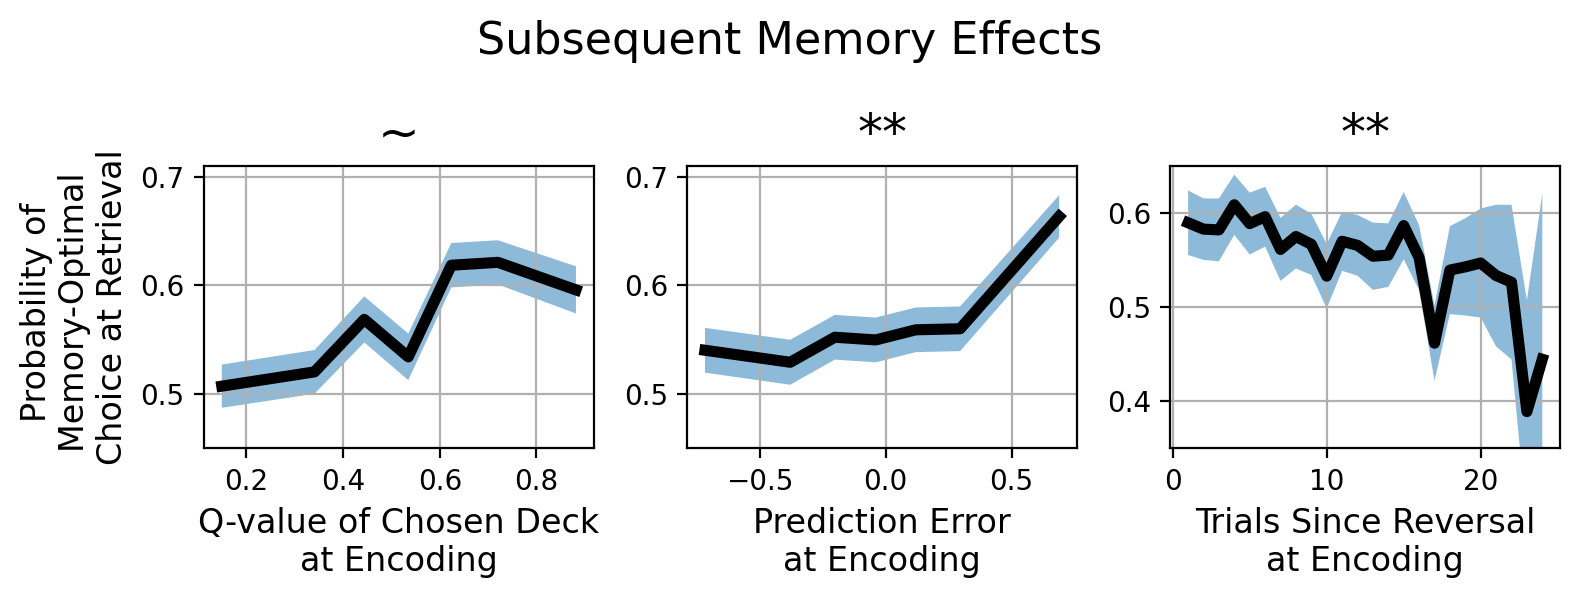

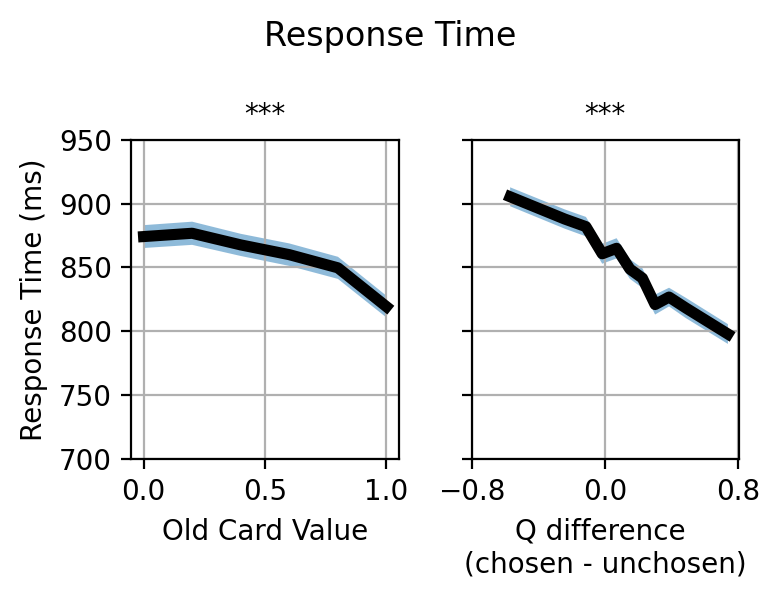

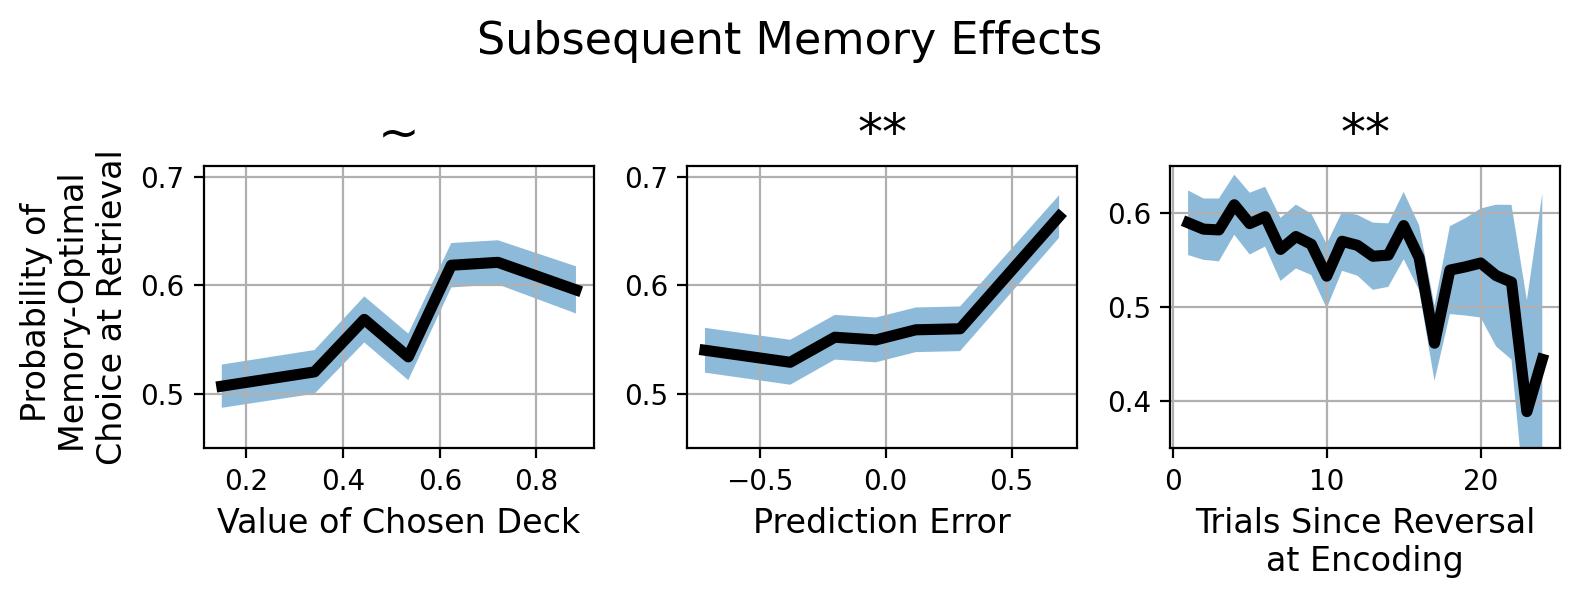

In [10]:
### SUPPLEMENTAL 
pf.episodic_incremental(data, data2=data[(data.RevT>10)&(data.Outcome<0.5)],
                        x_cols = ['RevT','Q_chosen'], 
                        y_cols = ['LuckyDeckC','Switch_nexttrial'],
                        x_texts = ['Trials Since Reversal',"Q-value of Chosen Deck"], 
                        y_texts = ['Likelihood of Choosing Lucky Deck', "Likelihood of Switching Decks\nNext Trial"], 
                        subtitles=[ 'Lucky Deck Learning','Deck Switching after Bad Outcomes (<$0.5)'],
                        logistic_fit=False, shaded=True,ylim=(0.2,0.85))

pf.encoding_plot(data, x_cols = ['Q_chosen','PE_enc','EncRevT'], nbins=7,
                       x_texts=["Q-value of Chosen Deck\nat Encoding",'Prediction Error\nat Encoding', 'Trials Since Reversal\nat Encoding'],
                       subtitles=['~','**','**'],
                       title='Subsequent Memory Effects')

pf.rt_plot(data, x_cols = ['ObjPP','Q_diff'], nbins=11,
                       x_texts= ["Old Card Value",'Q difference \n(chosen - unchosen)'],
                       subtitles=['***','***'],
                       title='Response Time')

pf.encoding_plot(data, x_cols = ['Q_chosen','PE_enc','EncRevT'], nbins=7,
                       x_texts=["Value of Chosen Deck",'Prediction Error', 'Trials Since Reversal\nat Encoding'],
                       subtitles=['~','**','**'],
                       title='Subsequent Memory Effects')

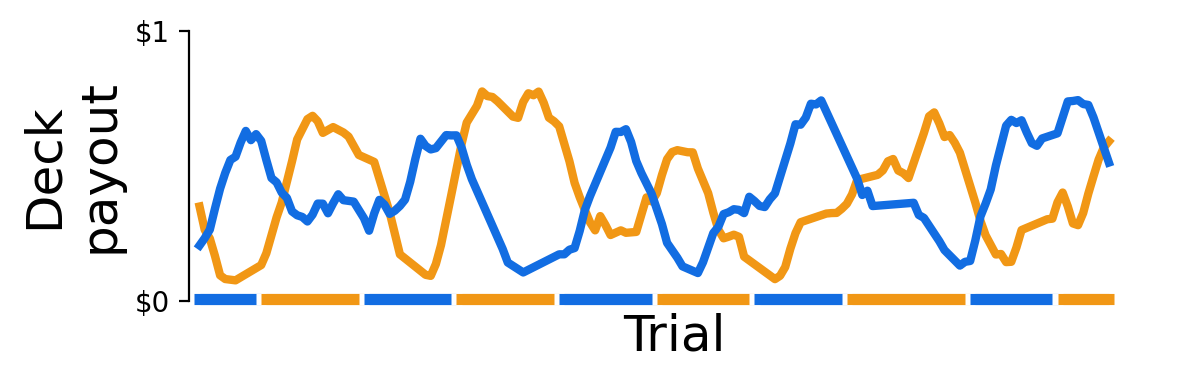

In [3]:
### example Q-value figure

# for sub in [7, 12, 18]: # data.Sub.unique()
sub = 18
trials_to_include = list(range(110,288))
subdata = data[(data.Sub == sub) & (~data.Q_red.isna()) & (~data.Q_blue.isna())].reset_index()

qred_smooth = subdata.Q_red.rolling(window=10, center=True).mean()
qblue_smooth = subdata.Q_blue.rolling(window=10, center=True).mean()

plt.figure(figsize=(6,2), dpi=200)

last = subdata.LuckyDeck.iloc[trials_to_include[0]]
for i,trial in enumerate(trials_to_include):
    lucky = subdata.LuckyDeck[trial]
    if lucky != last:
        color = 'white'
    elif lucky == 2:
        color = '#f19715'
    else:
        color = '#126de2'
    last = lucky
    ## FOR X-AXIS LINES
    plt.hlines(y=0.006, xmin=i-1, xmax=i+1, color=color, linewidth=4, clip_on=False, alpha=1)
    ## FOR LINES JUST ABOVE THE X-AXIS (remember to comment out the line below removing x-axis)
    # plt.hlines(y=0.032, xmin=i-1, xmax=i+1, color=color, linewidth=4, clip_on=False, alpha=1)
    ## FOR HIGHLIGHTING INSTEAD:
    # plt.hlines(y=0.5, xmin=i, xmax=i+1, color=color, linewidth=95, clip_on=False, alpha=0.3)

plt.plot(qred_smooth.values[trials_to_include], color='#f19715', linewidth=3)
plt.plot(qblue_smooth.values[trials_to_include], color='#126de2', linewidth=3)

# remove axes
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# plt.hlines(y=0, xmin=0, xmax=10, color='#f19715', linewidth=5)

plt.xticks([])
plt.yticks([0,1], labels=['$0','$1'])
# plt.yticklabels(['$0','$1'])
plt.xlabel('Trial', fontsize=18)
plt.ylabel('Deck\npayout', fontsize=18)
plt.ylim(0,)
plt.xlim(-2,)
plt.tight_layout()
plt.show()


### Overall simple

overall participant reward/performance (per run)

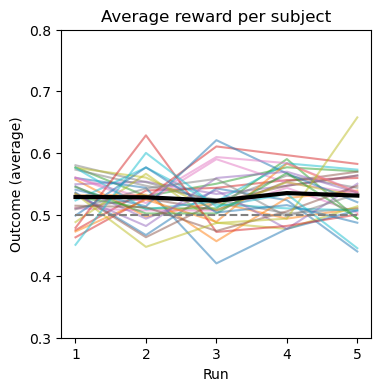

In [80]:
pf.overall_plot(data, x_var='Run', y_var='Outcome', grouping_var='Sub', mean=True,
                xticks=[1,2,3,4,5],ylim=(0.3,0.8), chance = 0.5, title ='Average reward per subject')

overall participant memory performance for each run

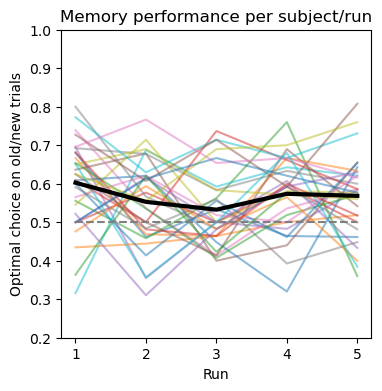

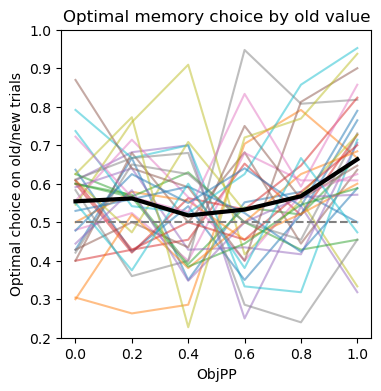

KeyboardInterrupt: 

In [81]:
pf.overall_plot(data, x_var='Run', y_var='OptObj', grouping_var='Sub', mean=True,
                xticks=[1,2,3,4,5],ylim=(0.2,1), chance = 0.5, ylabel='Optimal choice on old/new trials',
                title ='Memory performance per subject/run')

pf.overall_plot(data, x_var='ObjPP', y_var='OptObj', grouping_var='Sub', mean=True,
                ylim=(0.2,1), chance = 0.5, ylabel='Optimal choice on old/new trials',
                title ='Optimal memory choice by old value')
pf.overall_boxplot(data, y_var='OptObj', grouping_var='Sub',ylim=(0.4,0.8), chance = 0.5, xlim=(0.9,1.1),
                   ylabel='Optimal choice on old/new trials', title ='Memory performance per subject')
pf.overall_boxplot(data[data.ObjPP==1], y_var='OptObj', grouping_var='Sub', chance = 0.5, xlim=(0.9,1.1),
                   ylabel='Optimal choice on old/new trials', title ='Memory performance per subject  \n (only high-value items)')

overall memory bias

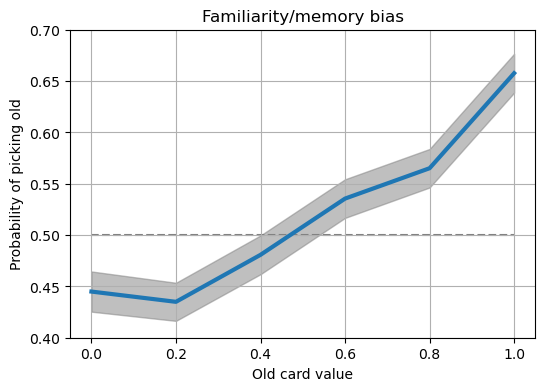

In [ ]:
pf.simple_plot(data, x_var='ObjPP', y_var = 'OldObjC', ylim=(0.4,0.7), chance=0.5,
             xlabel='Old card value', ylabel='Probability of picking old',
             title='Familiarity/memory bias')

did participants show an overall bias to a DeckC or a Resp?  or overall memory bias

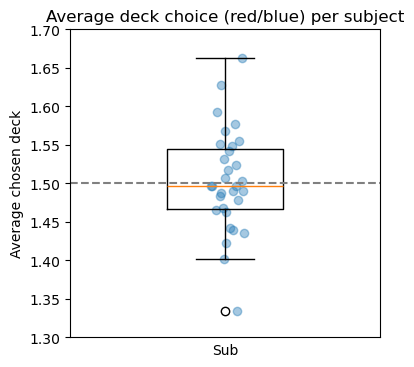

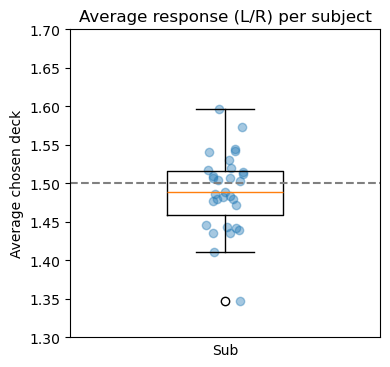

In [ ]:
pf.overall_boxplot(data, y_var='DeckC', grouping_var='Sub', chance = 1.5, ylabel='Average chosen deck',
                   ylim=(1.3,1.7),xlim=(0.8,1.2),title ='Average deck choice (red/blue) per subject')
## BY RUN:
# pf.overall_plot(data, x_var='Run', y_var='DeckC', grouping_var='Sub', mean=True,
#                 xticks=[1,2,3,4,5], chance = 1.5, ylabel='Average chosen deck',ylim=(1,2),yticks=(1,1.5,2),
#                 title ='Average deck choice (red/blue) per subject')

pf.overall_boxplot(data, y_var='Resp', grouping_var='Sub', chance = 1.5, ylabel='Average chosen deck',
                   ylim=(1.3,1.7),xlim=(0.8,1.2),title ='Average response (L/R) per subject')
## BY RUN:
# pf.overall_plot(data, x_var='Run', y_var='Resp', grouping_var='Sub', mean=True,
#                 xticks=[1,2,3,4,5], chance = 1.5, ylabel='Average chosen deck',ylim=(1,2),yticks=(1,1.5,2),
#                 title ='Average response (L/R) per subject')

did last trial's payment affect this trial's deck selection?

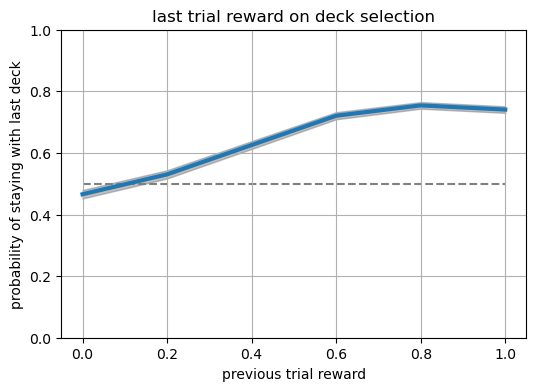

In [ ]:
pf.simple_plot(data, x_var='PP', y_var = 'StayResp', ylim=(0,1), chance=0.5,
             xlabel='previous trial reward', ylabel='probability of staying with last deck',
             title='last trial reward on deck selection')

### Episodic / incremental

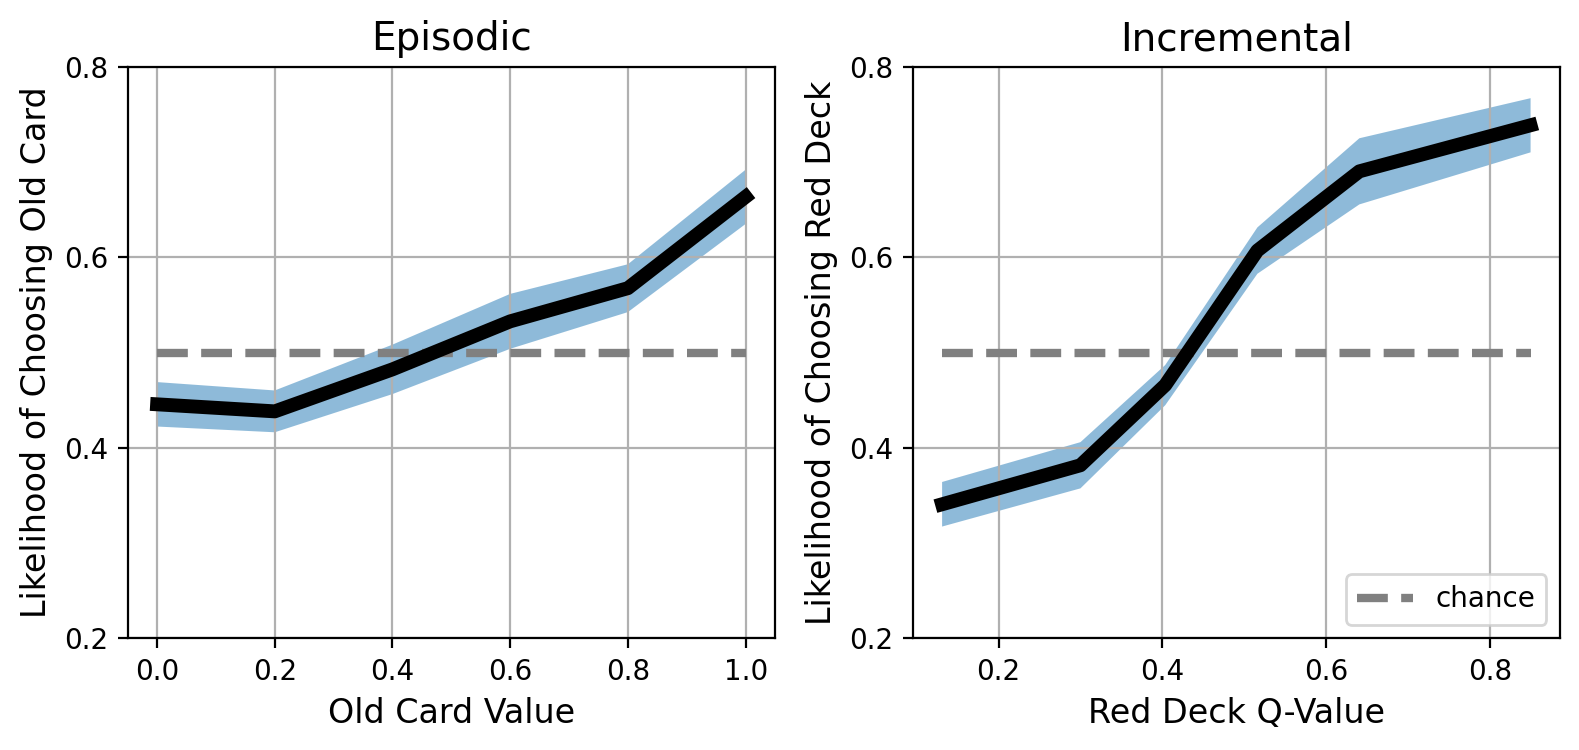

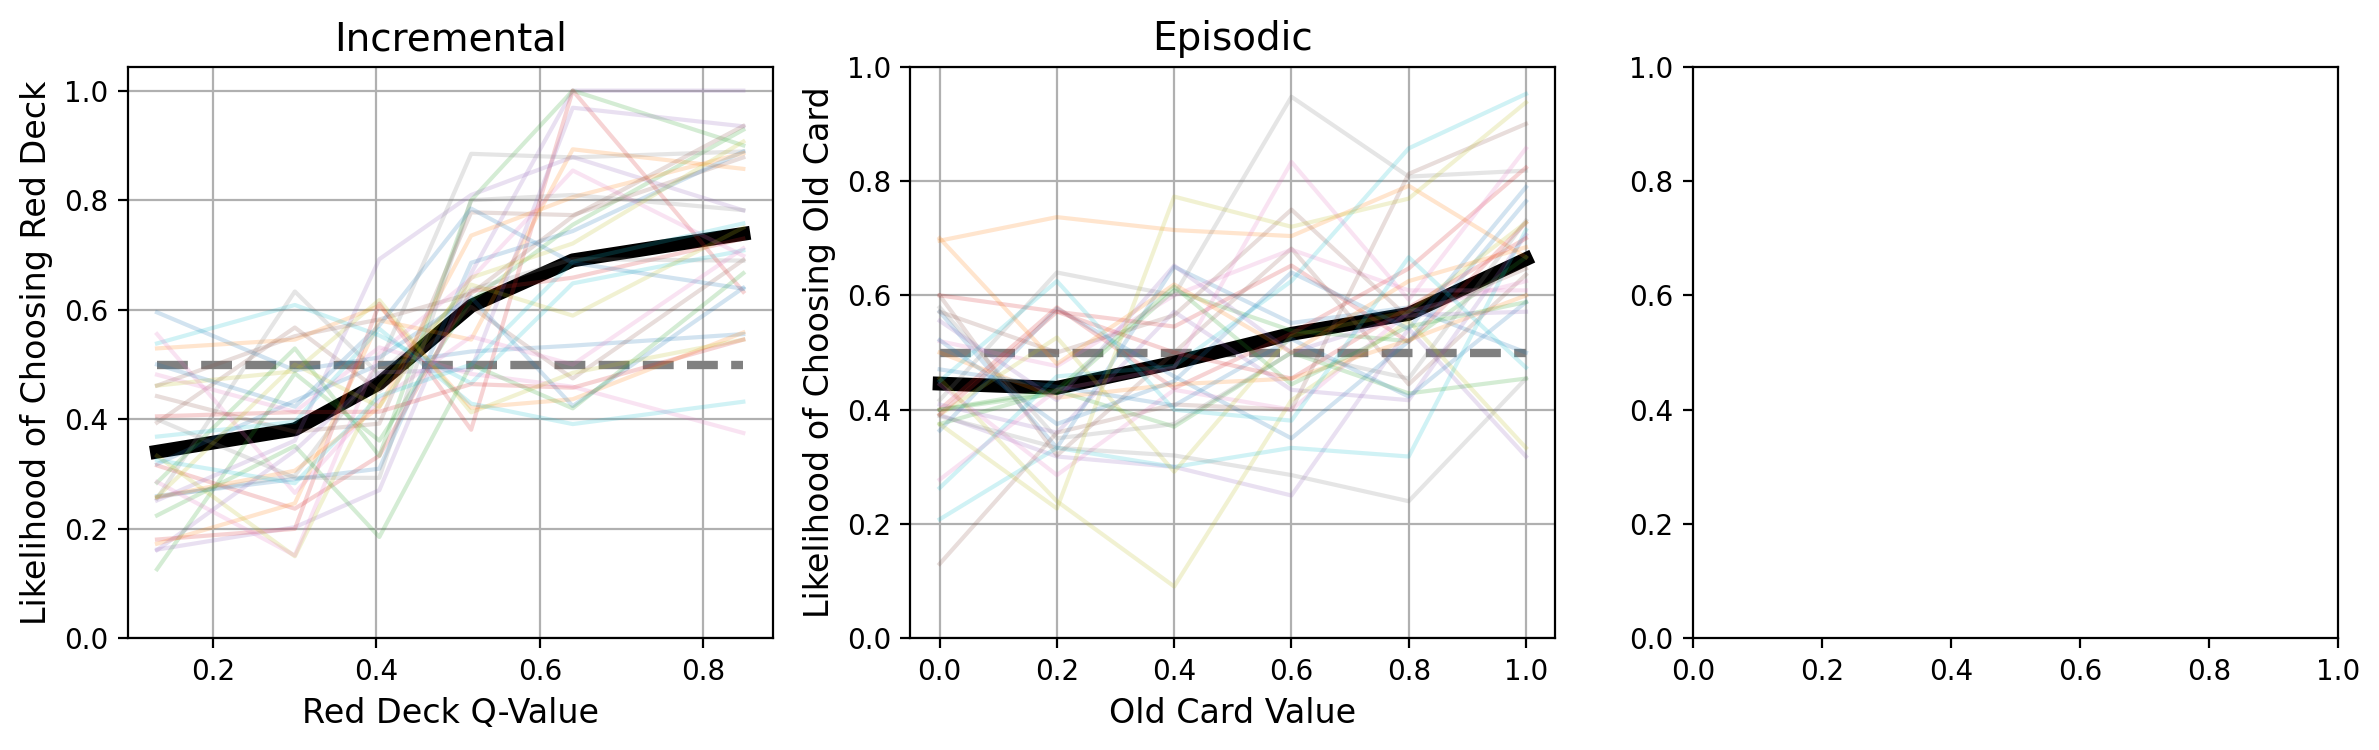

In [5]:
pf.episodic_incremental(data, 
                        x_cols = ['ObjPP','Q_red'], 
                        y_cols = ['OldObjC','ChooseRed'],
                        x_texts = ["Old Card Value",'Red Deck Q-Value'], 
                        y_texts = ["Likelihood of Choosing Old Card", 'Likelihood of Choosing Red Deck'], 
                        subtitles=['Episodic','Incremental'], 
                        logistic_fit=False, shaded=True, ylim=(0.2,0.8))

pf.episodic_incremental(data, 
                        x_cols = ['Q_red','ObjPP','RevT'],  # 
                        y_cols = ['ChooseRed','OldObjC','LuckyDeckC'], # 
                        x_texts = ['Red Deck Q-Value',"Old Card Value",'Trials Since Reversal'], # 
                        y_texts = [ 'Likelihood of Choosing Red Deck', "Likelihood of Choosing Old Card", 'Likelihood of Choosing Lucky Deck'], #
                        subtitles=[ 'Incremental','Episodic', 'Reversal Learning'], # 
                        logistic_fit=False, shaded=False)


do participants use incremental information? 

/Users/chrisiyer/_Current/lab/code/hybrid_rl/fmri_analysis/behavior_plotting_fxns.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_data = data.groupby(x_var)[y_var].agg(['count','mean','sem'])
/Users/chrisiyer/_Current/lab/code/hybrid_rl/fmri_analysis/behavior_plotting_fxns.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_data2 = data.groupby(x_var)[y2].mean()


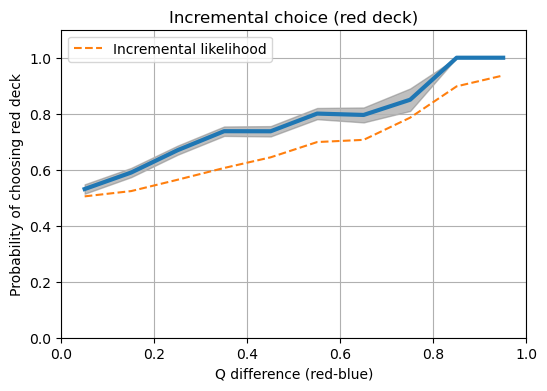

/Users/chrisiyer/_Current/lab/code/hybrid_rl/fmri_analysis/behavior_plotting_fxns.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_data = data.groupby(x_var)[y_var].agg(['count','mean','sem'])
/Users/chrisiyer/_Current/lab/code/hybrid_rl/fmri_analysis/behavior_plotting_fxns.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_data2 = data.groupby(x_var)[y2].mean()


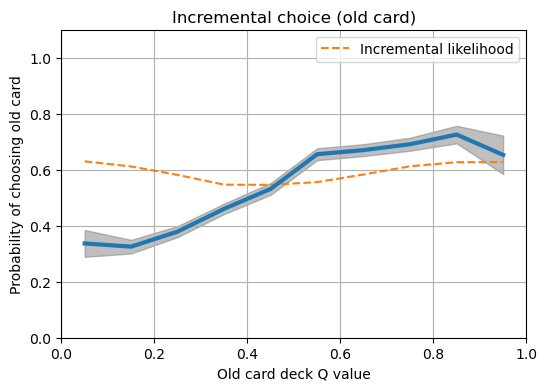

In [ ]:
#   red deck q value vs likelihood of choosing red deck
data['Q_diff_rb'] = data['Q_red'] - data['Q_blue']
pf.simple_plot(data, x_var='Q_diff_rb', y_var='ChooseRed', bin=True, bins = np.linspace(0,1,11),
               xlabel='Q difference (red-blue)', ylabel='Probability of choosing red deck',
               y2='Inc_lik', y2_label = 'Incremental likelihood', legend=True, ylim=(0,1.1), xticks=np.arange(6)/5,
               title='Incremental choice (red deck)')

#   old card deck q-value vs. likelihood of choosing deck
data["Q_old"] = np.select(
    [data["OldDeck"] == 2, data["OldDeck"] == 1],  
    [data["Q_red"], data["Q_blue"]],  
    default=np.nan  
)
pf.simple_plot(data, x_var='Q_old', y_var='OldObjC', bin=True, bins = np.linspace(0,1,11),
               xlabel='Old card deck Q value', ylabel='Probability of choosing old card',
               y2='Inc_lik', y2_label = 'Incremental likelihood', legend=True, ylim=(0,1.1), xticks=np.arange(6)/5,
               title='Incremental choice (old card)')

do participants use episodic information? old card value vs. likelihood of choosing it

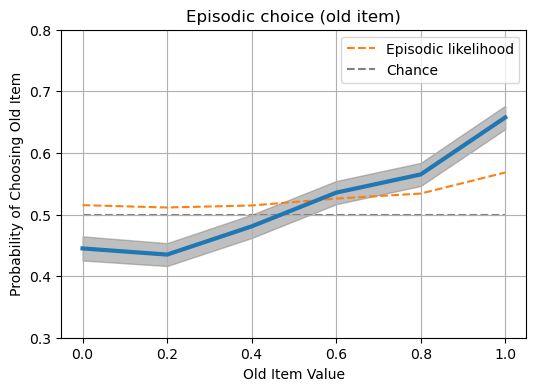

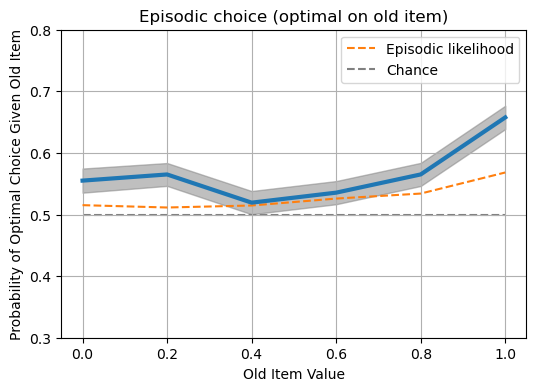

In [ ]:
# old value vs old choice
pf.simple_plot(data, x_var='ObjPP', y_var='OldObjC', ylim=(0.3,0.8), chance=0.5,
               xlabel='Old Item Value', ylabel='Probability of Choosing Old Item',
               y2='Ep_lik', y2_label = 'Episodic likelihood', legend=True,
               title='Episodic choice (old item)')
# old value vs. optimal choice
pf.simple_plot(data, x_var='ObjPP', y_var='OptObj', ylim=(0.3,0.8),chance=0.5,
               xlabel='Old Item Value', ylabel='Probability of Optimal Choice Given Old Item',
               y2='Ep_lik', y2_label = 'Episodic likelihood', legend=True,  
               title='Episodic choice (optimal on old item)')

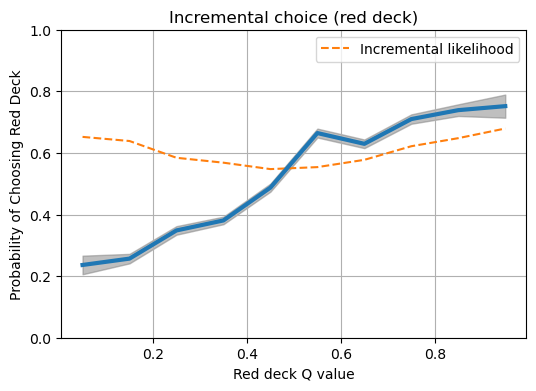

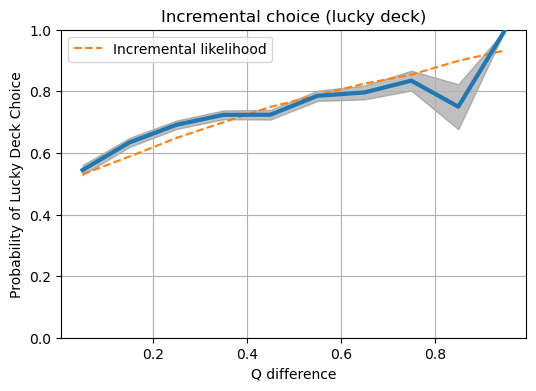

In [ ]:
# do participants use incremental information? 
#   red deck q value vs likelihood of choosing red deck

pf.simple_plot(data, x_var='Q_red', y_var='ChooseRed', bin=True, bins = np.linspace(0,1,11),
               ylim=(0,1),
               xlabel='Red deck Q value', ylabel='Probability of Choosing Red Deck',
               y2='Inc_lik', y2_label = 'Incremental likelihood', legend=True,
               title='Incremental choice (red deck)')
pf.simple_plot(data, x_var='Q_diff', y_var='LuckyDeckC', bin=True, bins = np.linspace(0,1,11),
               ylim=(0,1),
               xlabel='Q difference', ylabel='Probability of Lucky Deck Choice',
               y2='Inc_lik', y2_label = 'Incremental likelihood', legend=True,
               title='Incremental choice (lucky deck)')

#   old card deck q-value vs. likelihood of choosing deck

### Encoding effects

In [ ]:
new_columns = [
    "Outcome_enc","Q_chosen_enc", "PE_enc", "PE_enc_unsigned", "PE_enc_sign",
    "PE_prevtrial_enc", "PE_prevtrial_enc_unsigned", "PE_prevtrial_enc_sign",
    "RT_enc","RevT_enc_centered"
]
for col in new_columns:
    data[col] = np.nan

for idx,row in data[data.OldT==1].iterrows():
    enc_idx = data[(data['Trial'] == row['encTrialNum']) & (data['Sub'] == row['Sub'])].index
    if len(enc_idx) == 0:
        continue
    enc_idx = enc_idx[0]

    data.at[idx, "Q_chosen_enc"] = data.at[enc_idx, "Q_chosen"]
    data.at[idx, "PE_enc"] = data.at[enc_idx, "PE"]
    if enc_idx != 0:
        data.at[idx, "PE_prevtrial_enc"] = data.at[enc_idx - 1, "PE"]
    data.at[idx, "RT_enc"] = np.log(data.at[enc_idx, "RT"])
    data.at[idx,'RevT_enc_centered'] = data.at[enc_idx,'RevT'] - 10

data['ObjPP_just1'] = float(row.ObjPP == 1) 
data['PE_enc_unsigned'] = data['PE_enc'].abs()
data['PE_enc_sign'] = np.sign(data['PE_enc'])
data['PE_prevtrial_enc_unsigned'] = data['PE_prevtrial_enc'].abs()
data['PE_prevtrial_enc_sign'] = np.sign(data['PE_prevtrial_enc'])

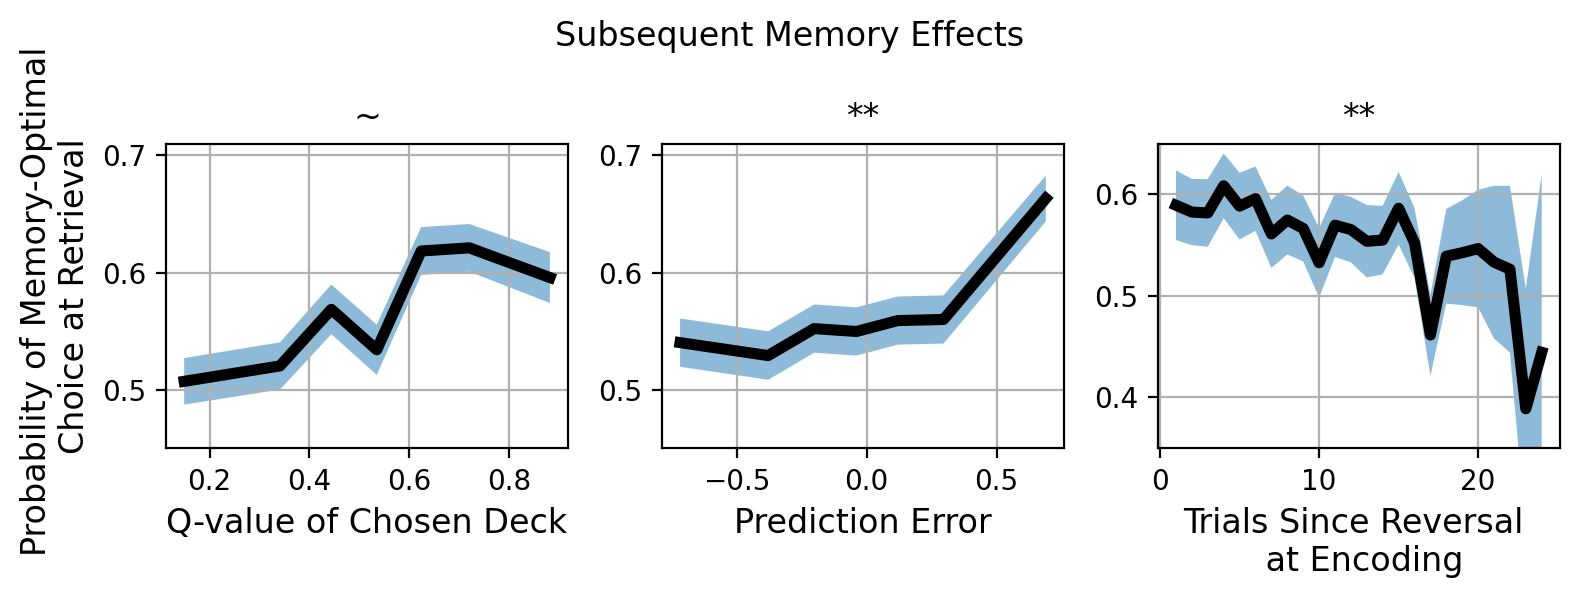

In [169]:
# encoding by RevT, Q_chosen, and PE
pf.encoding_plot(data, x_cols = ['Q_chosen','PE_enc','EncRevT'], nbins=7,
                       x_texts=["Q-value of Chosen Deck",'Prediction Error', 'Trials Since Reversal \n at Encoding'],
                       subtitles=['~','**','**'],
                       title='Subsequent Memory Effects')

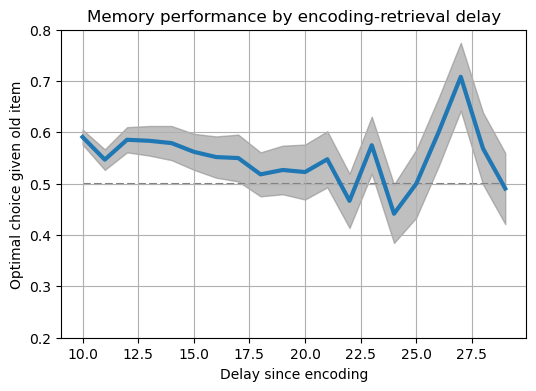

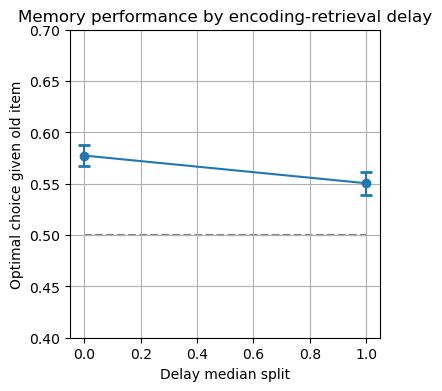

In [ ]:
pf.simple_plot(data, x_var='Delay',y_var='OptObj',xlabel='Delay since encoding', ylabel='Optimal choice given old item',
               ylim=(0.2,0.8), chance=0.5, title='Memory performance by encoding-retrieval delay')

# median split
data['Delay_bool'] = data.Delay > data.Delay.median()
pf.simple_plot_pair(data, x_var='Delay_bool',y_var='OptObj',xlabel='Delay median split', ylabel='Optimal choice given old item',
               ylim=(0.4,0.7), chance=0.5, title='Memory performance by encoding-retrieval delay')

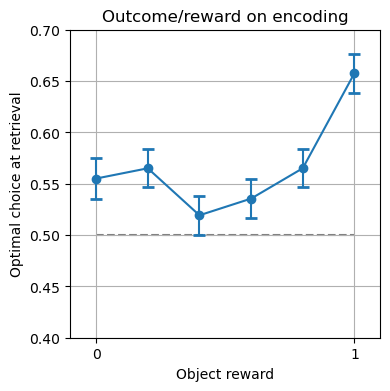

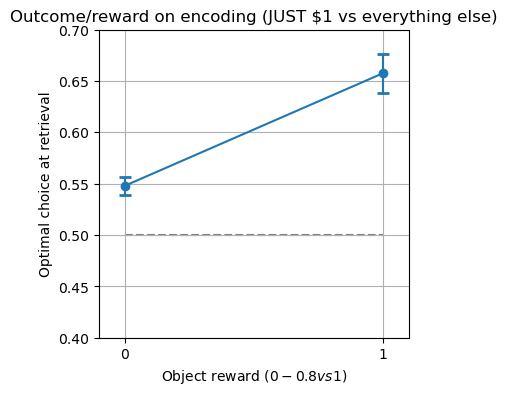

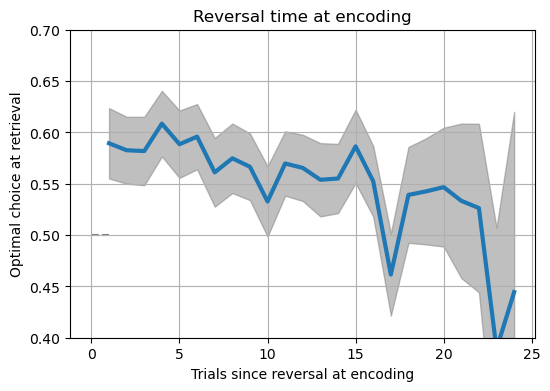

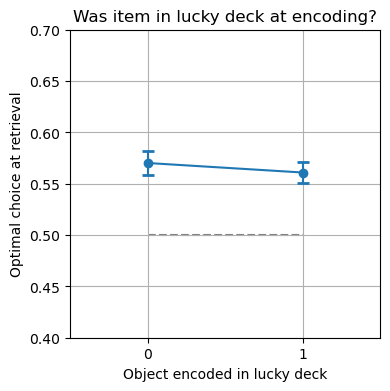

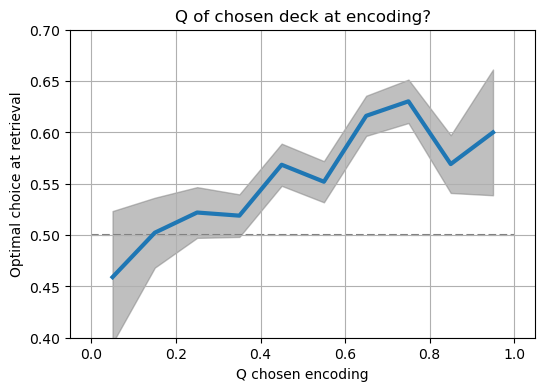

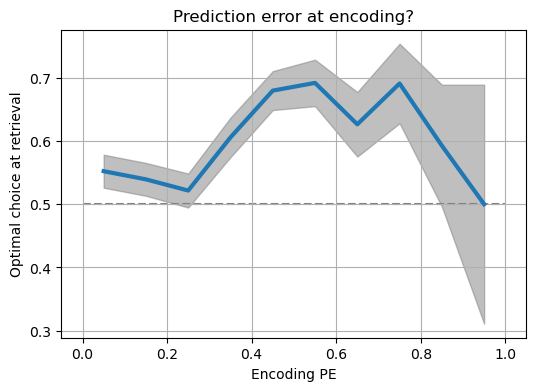

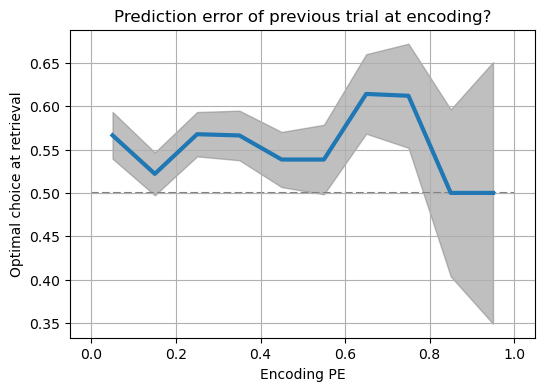

In [ ]:
# reward encoding
pf.simple_plot_pair(data, x_var='ObjPP',y_var='OptObj', chance=0.5,
                  xlabel = 'Object reward', 
                  ylabel='Optimal choice at retrieval',
                  title='Outcome/reward on encoding',
                  xlim=(-0.1,1.1), xticks=(0,1),ylim=(0.4,0.7))

pf.simple_plot_pair(data, x_var='ObjPP_just1',y_var='OptObj', chance=0.5,
                  xlabel = 'Object reward ($0-0.8 vs $1)', 
                  ylabel='Optimal choice at retrieval',
                  title='Outcome/reward on encoding (JUST $1 vs everything else)',
                  xlim=(-0.1,1.1), xticks=(0,1),ylim=(0.4,0.7))

# revt
pf.simple_plot(data, x_var='EncRevT',y_var='OptObj', chance=0.5,
                  xlabel = 'Trials since reversal at encoding', 
                  ylabel='Optimal choice at retrieval',
                  title='Reversal time at encoding', ylim=(0.4,0.7))

# # was it in the first half of encoding revT
# pf.simple_plot_pair(data, x_var='pre_post_rev_enc',y_var='OptObj', chance=0.5,
#                   xlabel = 'Object in first or second half of reversal block', 
#                   ylabel='Optimal choice at retrieval',
#                   title='Was item encoded in first or second half of reversal block?',
#                   xlim=(-1,1), xticks=(-0.5,0.5),ylim=(0.4,0.7))

# was it in the lucky deck at time of encoding
pf.simple_plot_pair(data, x_var='OldObjLuckyDeckEnc',y_var='OptObj', chance=0.5,
                  xlabel = 'Object encoded in lucky deck', 
                  ylabel='Optimal choice at retrieval',
                  title='Was item in lucky deck at encoding?',
                  xlim=(-0.5,1.5), xticks=(0,1),ylim=(0.4,0.7))

# q chosen at time of encoding
pf.simple_plot(data, x_var='Q_chosen',y_var='OptObj', chance=0.5,
                  xlabel = 'Q chosen encoding', bins=np.arange(11)/10,
                  ylabel='Optimal choice at retrieval',
                  title='Q of chosen deck at encoding?',
                  ylim=(0.4,0.7))

# PE at time of encoding
pf.simple_plot(data, x_var='PE_enc',y_var='OptObj', chance=0.5,
                  xlabel = 'Encoding PE', bins=np.arange(11)/10,
                  ylabel='Optimal choice at retrieval',
                  title='Prediction error at encoding?',)

# PE of previous trial at time of encoding
pf.simple_plot(data, x_var='PE_prevtrial_enc',y_var='OptObj', chance=0.5,
                  xlabel = 'Encoding PE', bins=np.arange(11)/10,
                  ylabel='Optimal choice at retrieval',
                  title='Prediction error of previous trial at encoding?',)


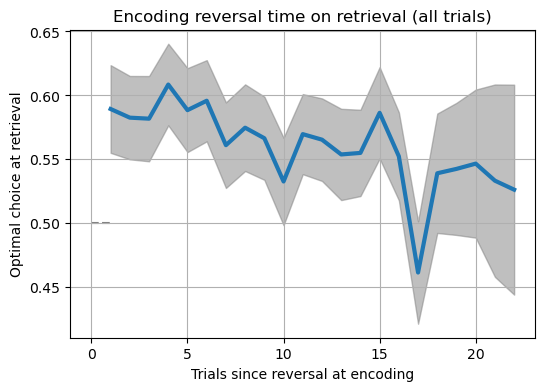

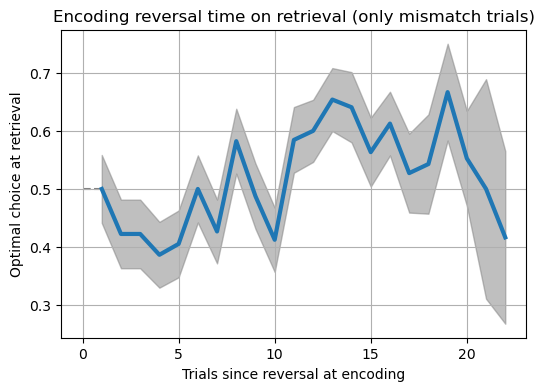

In [ ]:
# dig deeper into the idea that people are worse at retrieval trials the further the encoding trial is into the reversal
# did you select appropriately on the old item when the choice contradicts what you would've made by Q judgement
# meaning, chose a good (>0.5) item in the unluckier deck (Q_diff will be negative) 
#   or, avoided a bad (<0.5) item in the luckier deck (Q_diff will also be negative) 

pf.simple_plot(data[(data.EncRevT<23)], x_var='EncRevT',y_var='OptObj', chance=0.5,
                  xlabel = 'Trials since reversal at encoding', 
                  ylabel='Optimal choice at retrieval',
                  title='Encoding reversal time on retrieval (all trials)')

pf.simple_plot(data[(data.Q_diff<0)&(data.EncRevT<23)], x_var='EncRevT',y_var='OptObj', chance=0.5,
                  xlabel = 'Trials since reversal at encoding', 
                  ylabel='Optimal choice at retrieval',
                  title='Encoding reversal time on retrieval (only mismatch trials)')

# what?? people are BETTER at the mismatch trials with enc rev T?

### Reversal effects

In [ ]:
#### RAPHAEL'S INTERACTION PLOTS WERE ONLY COMPUTED IN R!!!

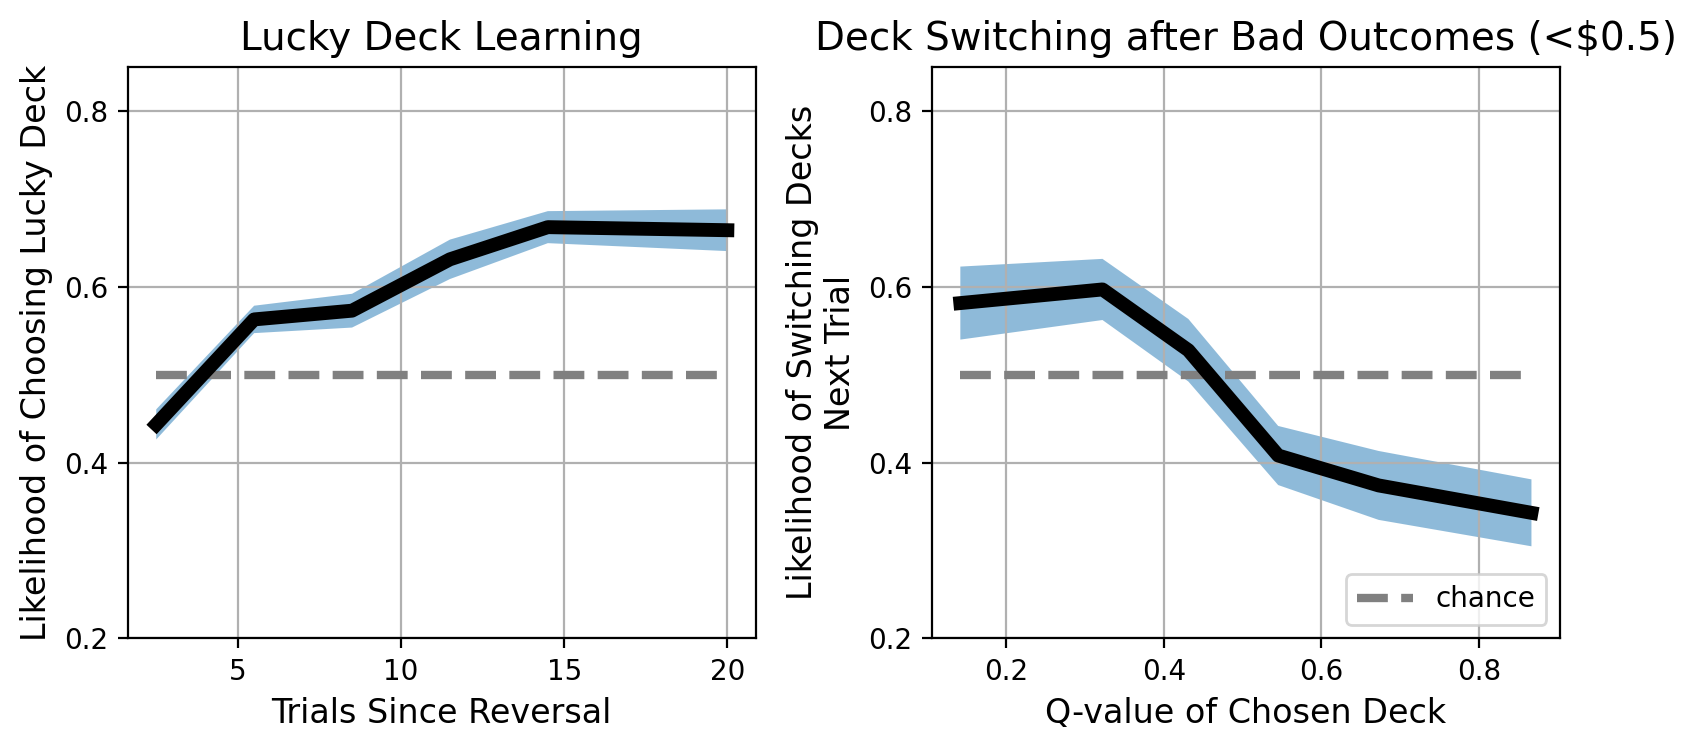

In [ ]:
data['Switch_nexttrial'] = (~data.StayResp.astype(bool)).astype(int).shift(-1)
pf.episodic_incremental(data, data2=data[(data.RevT>10)&(data.Outcome<0.5)],
                        x_cols = ['RevT','Q_chosen'], 
                        y_cols = ['LuckyDeckC','Switch_nexttrial'],
                        x_texts = ['Trials Since Reversal',"Q-value of Chosen Deck"], 
                        y_texts = ['Likelihood of Choosing Lucky Deck', "Likelihood of Switching Decks\nNext Trial"], 
                        subtitles=[ 'Lucky Deck Learning','Deck Switching after Bad Outcomes (<$0.5)'],
                        logistic_fit=False, shaded=True,ylim=(0.2,0.85))

within the first few trials of a reversal, do old trials help people infer reversal? 
- THEY SHOUDLN'T! If old value and deck value are decorrelated, then old trials should be uninformative about the lucky deck

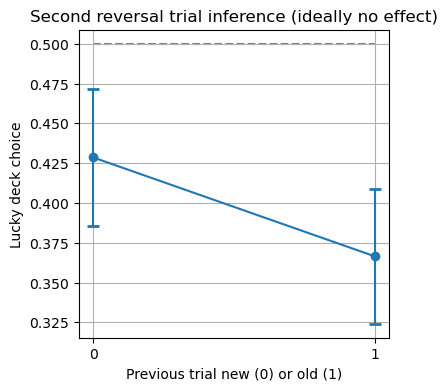

In [ ]:
# new_after_new = {1:[],2:[],3:[],4:[],5:[]}
# new_after_old= {1:[],2:[],3:[],4:[],5:[]}
second_trial_data = pd.DataFrame(columns=['prev_OldT', 'LuckyDeckC'])
for i in range(len(data)):
    if (data.RevT[i] == 2) & (data.OldT[i] == 0): # new trial on second of a reversal
        second_trial_data.loc[len(second_trial_data)] = [data.OldT[i-1], data.LuckyDeckC[i]]

pf.simple_plot_pair(data=second_trial_data, x_var='prev_OldT',y_var='LuckyDeckC',
                    xlabel='Previous trial new (0) or old (1)', ylabel='Lucky deck choice',
                    chance = 0.5, xticks=((0,1)), title='Second reversal trial inference (ideally no effect)')

effect of reversal on overall performance, lucky deck choice, and on old card choice (+each run)


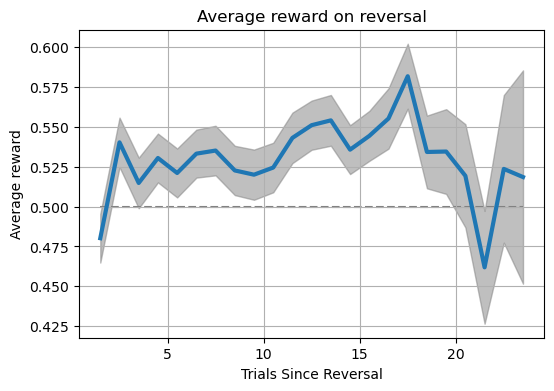

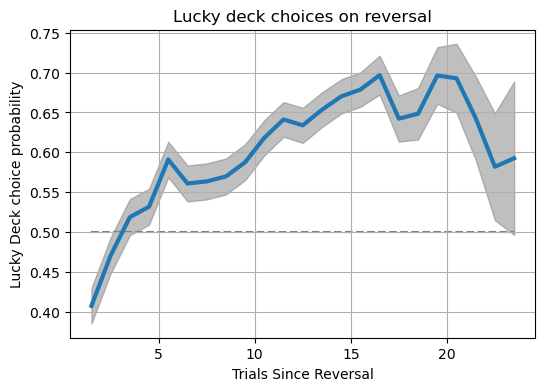

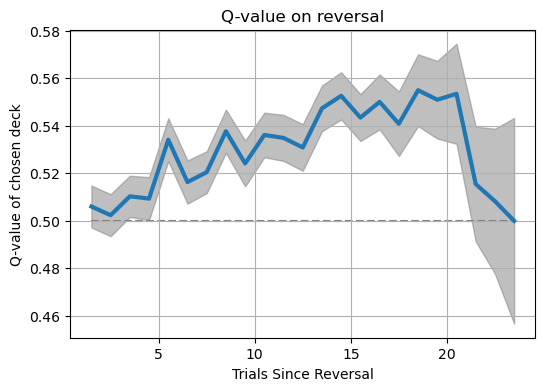

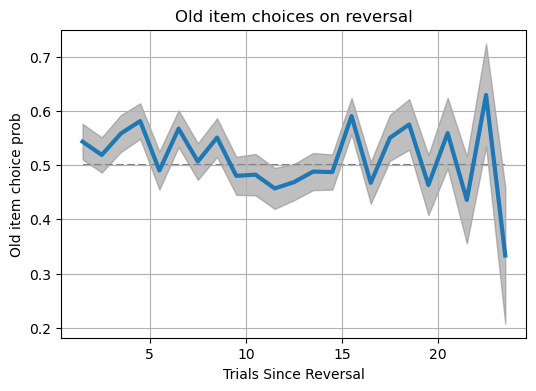

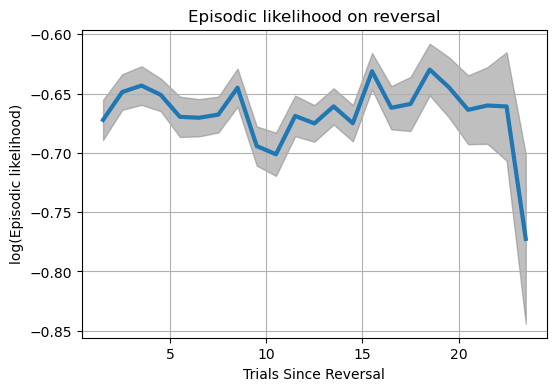

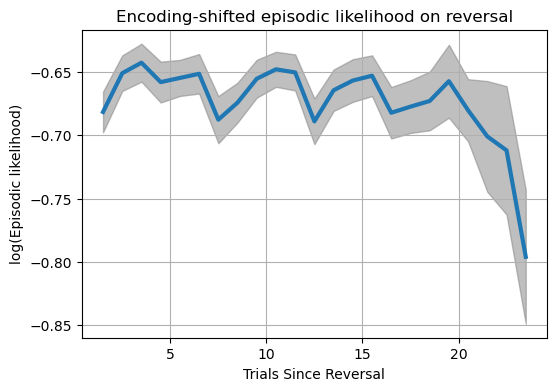

In [ ]:
# revT against overall performance
pf.simple_plot(data, x_var = 'RevT', y_var = 'Outcome', chance=0.5,
               xlabel = 'Trials Since Reversal', ylabel='Average reward',
               title = 'Average reward on reversal', bins = data.RevT.unique())

# revT against lucky deck choices
pf.simple_plot(data, x_var = 'RevT', y_var = 'LuckyDeckC',  chance=0.5,
               xlabel = 'Trials Since Reversal', ylabel='Lucky Deck choice probability',
               title = 'Lucky deck choices on reversal', bins = data.RevT.unique())
pf.simple_plot(data, x_var = 'RevT', y_var = 'Q_chosen',  chance=0.5,
               xlabel = 'Trials Since Reversal', ylabel='Q-value of chosen deck',
               title = 'Q-value on reversal', bins = data.RevT.unique())

# revT against old card choice
pf.simple_plot(data, x_var = 'RevT', y_var = 'OldObjC',  chance=0.5,
               xlabel = 'Trials Since Reversal', ylabel='Old item choice prob',
               title = 'Old item choices on reversal', bins = data.RevT.unique())

# revT against Episodic likelihood 
pf.simple_plot(data, x_var = 'RevT', y_var = 'Ep_lik',  
               xlabel = 'Trials Since Reversal', ylabel='log(Episodic likelihood)',
               title = 'Episodic likelihood on reversal', bins = data.RevT.unique())

# revT against encoding-shifted Episodic likelihood 
pf.simple_plot(data, x_var = 'RevT', y_var = 'Ep_lik_enc',  
               xlabel = 'Trials Since Reversal', ylabel='log(Episodic likelihood)',
               title = 'Encoding-shifted episodic likelihood on reversal', bins = data.RevT.unique())

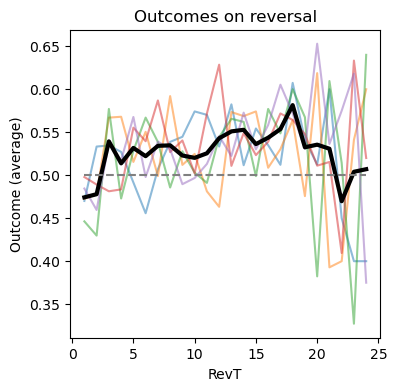

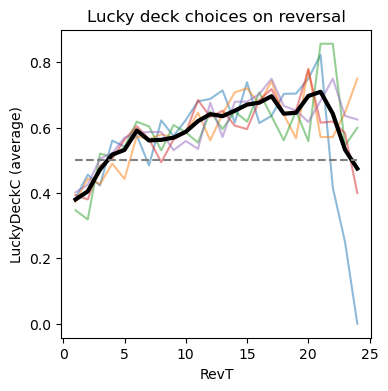

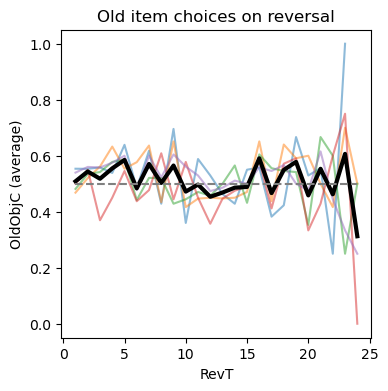

In [ ]:
# same but separating runs
# revT against overall performance
pf.overall_plot(data, x_var = 'RevT', y_var = 'Outcome', grouping_var='Run', chance=0.5,
               x_label = 'Trials Since Reversal', y_text='Average reward',
               title = 'Outcomes on reversal', bins = data.RevT.unique()) # , legend=True)
# revT against lucky deck choices
pf.overall_plot(data, x_var = 'RevT', y_var = 'LuckyDeckC', grouping_var='Run',  chance=0.5,
               x_label = 'Trials Since Reversal', y_text='Lucky deck choice prob',
               title = 'Lucky deck choices on reversal', bins = data.RevT.unique())# , legend=True)
# the blue line is being dragged down by just 1 unlucky trial

# revT against old card choice
pf.overall_plot(data, x_var = 'RevT', y_var = 'OldObjC',  grouping_var='Run', chance=0.5,
               x_label = 'Trials Since Reversal', y_text='Old item choice prob',
               title = 'Old item choices on reversal', bins = data.RevT.unique())# , legend=True)

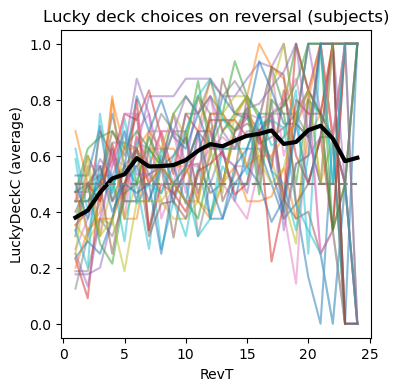

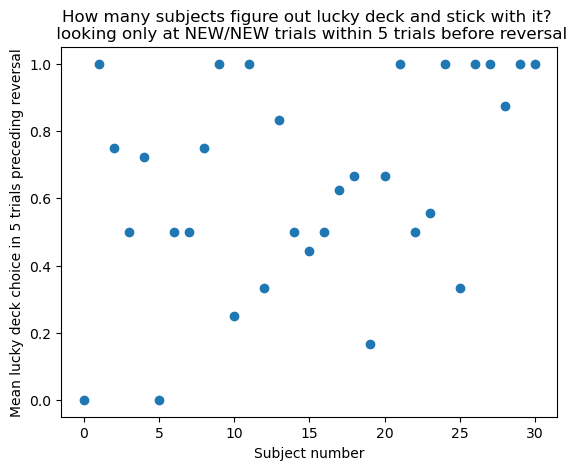

In [ ]:
# how variable are selections late in reversal? e.g., all-or-nothing lucky deck decision
# revT against lucky deck choices
pf.overall_plot(data, x_var = 'RevT', y_var = 'LuckyDeckC', grouping_var='Sub',  chance=0.5,
               x_label = 'Trials Since Reversal ', y_text='Lucky deck choice prob',
               title = 'Lucky deck choices on reversal (subjects)', bins = data.RevT.unique())# , legend=True)

g = data[data.OldT==0].groupby(['RevT','Sub']).mean()['LuckyDeckC'].reset_index() 
test = g[g.RevT>20].groupby('Sub').mean()['LuckyDeckC']
plt.scatter(np.arange(len(test)),test)
plt.title('How many subjects figure out lucky deck and stick with it? \n looking only at NEW/NEW trials within 5 trials before reversal')
plt.xlabel('Subject number')
plt.ylabel('Mean lucky deck choice in 5 trials preceding reversal')
plt.show()
# seems like only about half of them get it....

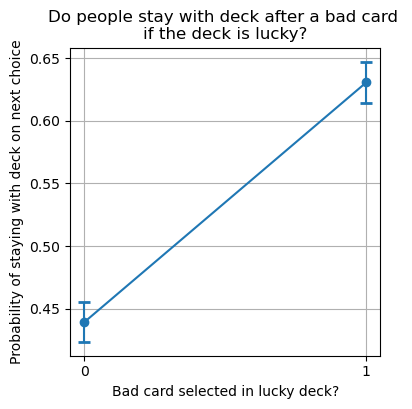

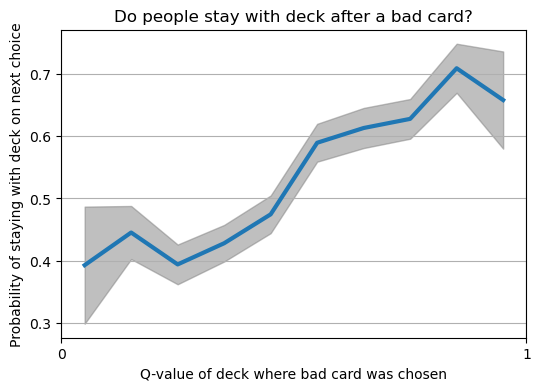

In [109]:
# when getting a bad card, should be less likely to switch when it's in the lucky deck 
#   look only in second half of reversal to hope the subjects have figured out lucky deck by now??
#   bad card = <0.5 or $0

data['bad_card'] = data.Outcome < 0.5 # ==0
data['last_card_bad'] = data.bad_card.shift(1)
data['last_card_lucky'] = data.LuckyDeckC.shift(1)
data['last_Q_chosen'] = data.Q_chosen.shift(1)

filt_data = data[(data.RevT>10) & (data.last_card_bad == 1)]
# plot: StayResp on y, last_card_l
pf.simple_plot_pair(data=filt_data, x_var='last_card_lucky', y_var='StayResp', xlabel='Bad card selected in lucky deck?',
                    ylabel='Probability of staying with deck on next choice',xticks=[0,1], title='Do people stay with deck after a bad card \nif the deck is lucky?')



pf.simple_plot(data=filt_data, x_var='last_Q_chosen', y_var='StayResp', bins=np.arange(11)/10,
               xlabel='Q-value of deck where bad card was chosen',
               ylabel='Probability of staying with deck on next choice',xticks=[0,1], 
               title='Do people stay with deck after a bad card?')


### Lingering memory modes

does the previous trial's memory performance bias the current trial?


- OBJECT USE: limit to just *consecutive* pairs of old/new trials
    - separate by memory performance (optimal choice) on first trial of the pair
    - plot value of old object vs. old choice for second trial of the pair 
- DECK USE: 
    - preceding deck outcome on the x, compare successful old/new last trial vs. wrong old/new last trial to prob of staying with deck 
- same as above, but instead of comparing previous trial correct old/new vs. incorrect old new, we will compare previous trial correct old/new vs. prev trial new/new

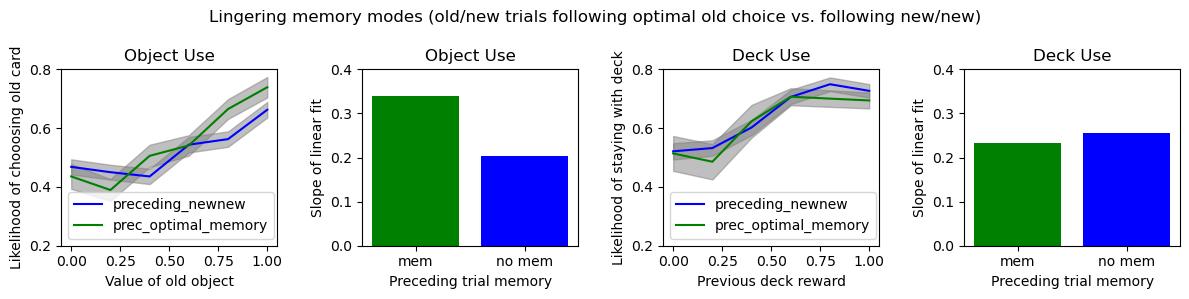

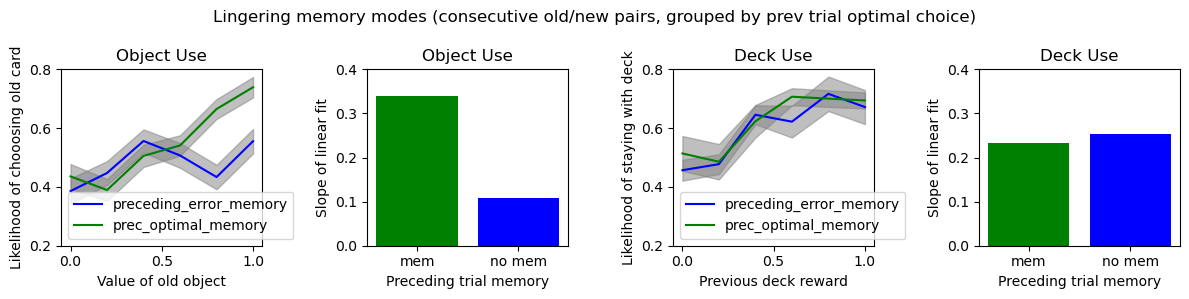

In [ ]:
pf.plot_lingering_modes(data, oldnew_vs_newnew=True,
                        title = 'Lingering memory modes (old/new trials following optimal old choice vs. following new/new)')

pf.plot_lingering_modes(data, oldnew_vs_newnew=False,
                        title = 'Lingering memory modes (consecutive old/new pairs, grouped by prev trial optimal choice)')


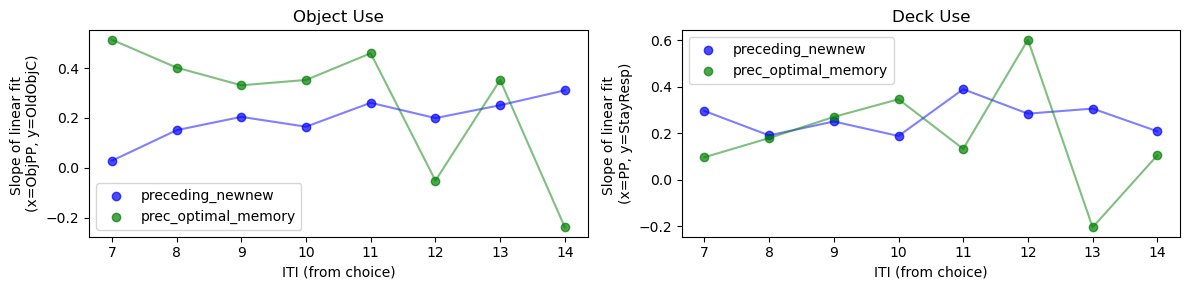

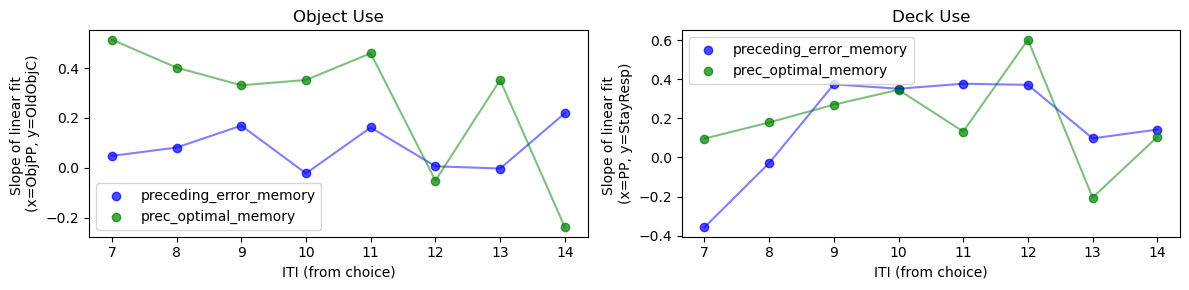

In [ ]:
data = pf.add_isi_to_data(data, save=True)
pf.plot_lingering_modes_iti(data, from_choice_or_fb='choice', oldnew_vs_newnew=True)

pf.plot_lingering_modes_iti(data, from_choice_or_fb='choice', oldnew_vs_newnew=False)
# oldnew_vs_newnew = True:compare preceding oldnew-optimal to preceding newnew trials
# oldnew_vs_newnew = True: compare preceding oldnew-optimal to preceding oldnew-nonoptimal trials
# from_choice_or_fb: where to start the ITI count (end of last choice, or last fb)

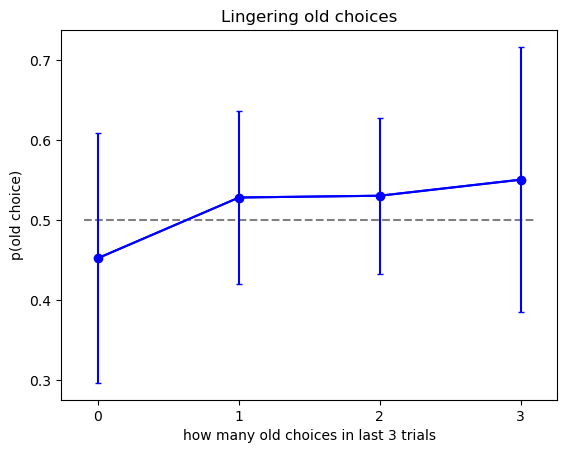

In [ ]:
p_old = []
for sub in data.Sub.unique():
    subdata = data[data.Sub == sub]
    sub_old = [0,0,0,0]
    totals = [0,0,0,0]
    for i,row in subdata.iterrows():
        if i > 2:
            if row.OldT==1:
                sum_prev_old = data.OldT.iloc[i-3:i].sum()
                totals[sum_prev_old] += 1
                if row.OldObjC==1:
                    sub_old[sum_prev_old] += 1
    sub_pold = np.array(sub_old) / np.array(totals)
    p_old.append(sub_pold)

p_old = np.array(p_old)

plt.figure()
plt.title('Lingering old choices')
plt.plot(np.mean(p_old, axis=0), color='blue', label='old choice')
plt.plot([-0.1,1,2,3.1],[0.5,0.5,0.5,0.5], color='gray', linestyle='--')
plt.scatter([0,1,2,3], np.mean(p_old, axis=0), color='blue')
plt.errorbar(x = [0,1,2,3], y=np.mean(p_old, axis=0), yerr=np.std(p_old, axis=0), capsize=2, color='blue')
plt.xlabel('how many old choices in last 3 trials')
plt.xticks([0,1,2,3])
plt.ylabel('p(old choice)')
plt.show()

### Understanding the likelihoods

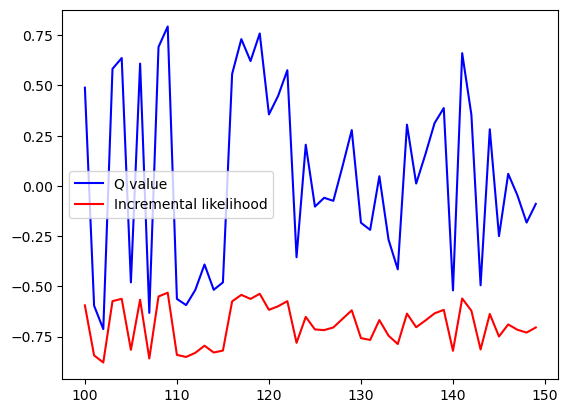

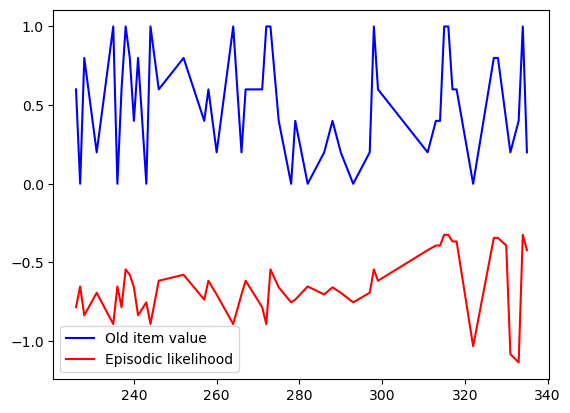

In [ ]:
# sanity check -- do Q value (Q_diff) and Inc_lik scale together? 
# do Old value and Ep_lik scale together?
i = 100
j = 50
plt.plot(data.Q_diff[i:i+j], color='blue', label='Q value')
plt.plot(data.Inc_lik[i:i+j], color='red', label='Incremental likelihood')
plt.legend()
plt.show()

plt.plot(data[data.OldT==1].ObjPP[i:i+j], color='blue', label='Old item value')
plt.plot(data[data.OldT==1].Ep_lik[i:i+j], color='red', label='Episodic likelihood')
plt.legend()
plt.show()

Episodic likelihood should account for:
- non-lucky deck choices (excluding trials after a reversal)
    - and especially non-lucky deck choices with Outcome > 0.5
- choice behavior when episodic value contradicts deck value 
    - i.e., should covary with OptObj when ObjDeckMatch==1 (mismatch)
        - when a good old object is in unlucky deck, or a bad old object in lucky deck

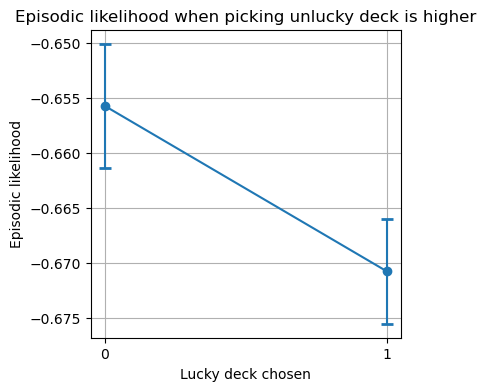

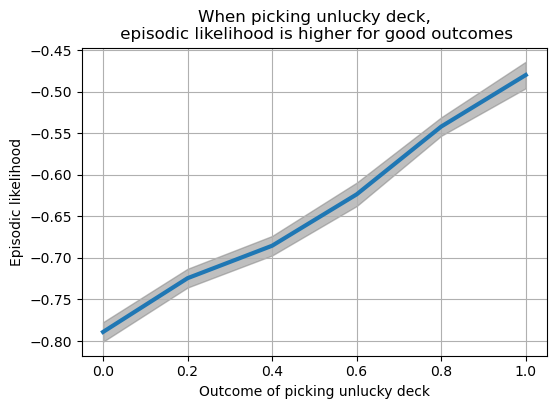

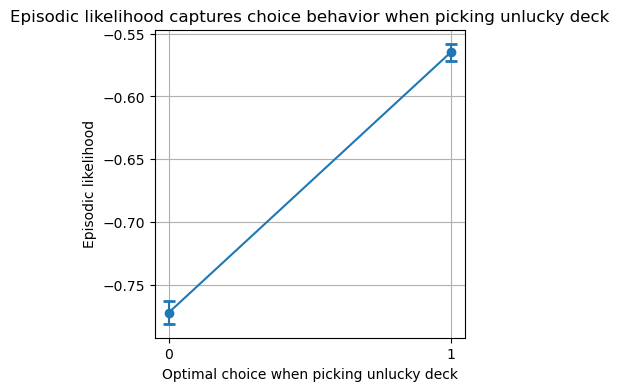

In [ ]:
pf.simple_plot_pair(data = data[data.OldT==1], x_var='LuckyDeckC', y_var='Ep_lik', xticks=((0,1)),
                    xlabel='Lucky deck chosen', ylabel='Episodic likelihood',
                    title='Episodic likelihood when picking unlucky deck is higher')

pf.simple_plot(data = data[(data.OldT==1) & (data.LuckyDeckC==0)], x_var='Outcome', y_var='Ep_lik',
                    xlabel='Outcome of picking unlucky deck', ylabel='Episodic likelihood',
                    title='When picking unlucky deck,\n episodic likelihood is higher for good outcomes')

pf.simple_plot_pair(data = data[(data.OldT==1) & (data.Q_diff<0)], x_var='OptObj', y_var='Ep_lik', xticks=((0,1)),
                    xlabel='Optimal choice when picking unlucky deck', ylabel='Episodic likelihood',
                    title='Episodic likelihood captures choice behavior when picking unlucky deck')

In [ ]:
# do we have enough mismatch trials to model in fMRI? in one session
test = data[(data.OldT==1) & (data.Q_diff<0)]
test =test[(test.Sub==2)&(test.Run==1)]
print("Optimal choices on mismatch:", len(test[test.OptObj==0]))
print("Non-optimal choices on mismatch:",len(test[test.OptObj==1]))

Optimal choices on mismatch: 3
Non-optimal choices on mismatch: 8


### RT 

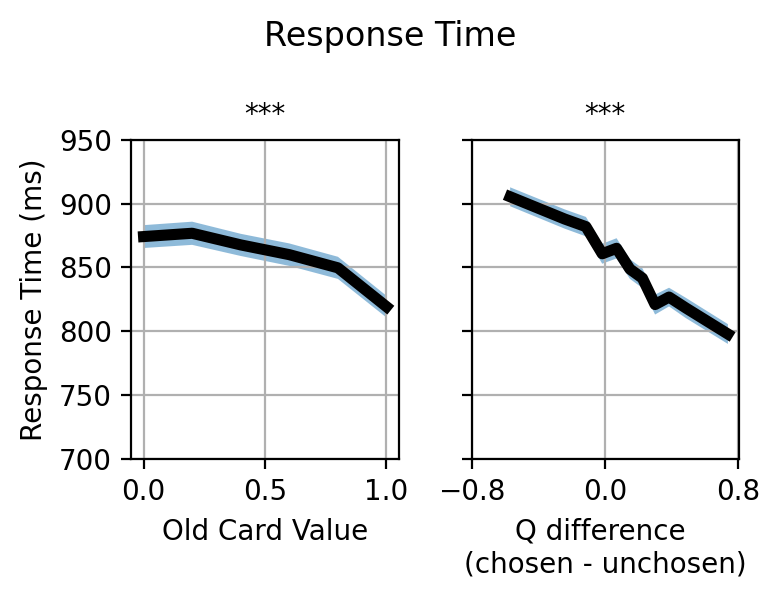

In [3]:
pf.rt_plot(data, x_cols = ['ObjPP','Q_diff'], nbins=11,
                       x_texts= ["Old Card Value",'Q difference \n(chosen - unchosen)'],
                       subtitles=['***','***'],
                       title='Response Time')

In [ ]:
from pymer4.models import Lmer
data['logRT'] = np.log(data.RT)
model = Lmer(
    "logRT ~  ObjPP + Q_diff + (1| Sub)",
    data=data[data.OldT==1]
)
model.fit()
print(model.summary())

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: logRT~ObjPP+Q_diff+(1|Sub)

Family: gaussian	 Inference: parametric

Number of observations: 4092	 Groups: {'Sub': 31.0}

Log-likelihood: 84.132 	 AIC: -158.264

Random effects:

                 Name    Var    Std
Sub       (Intercept)  0.017  0.129
Residual               0.054  0.233

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: logRT~ObjPP+Q_diff+(1|Sub)

Family: gaussian	 Inference: parametric

Number of observations: 4092	 Groups: {'Sub': 31.0}

Log-likelihood: 84.132 	 AIC: -158.264

Random effects:

                 Name    Var    Std
Sub       (Intercept)  0.017  0.129
Residual       

/Users/chrisiyer/miniconda3/envs/hbi/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "PE_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  warnings.warn('Error while trying to convert '
/Users/chrisiyer/miniconda3/envs/hbi/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Do episodic likelihood and RT correlate?

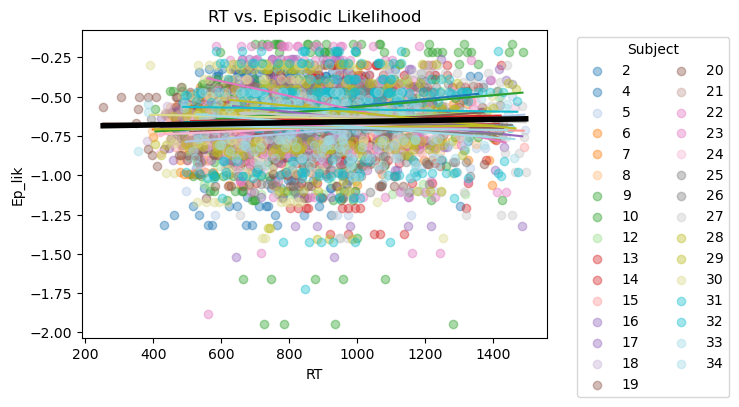

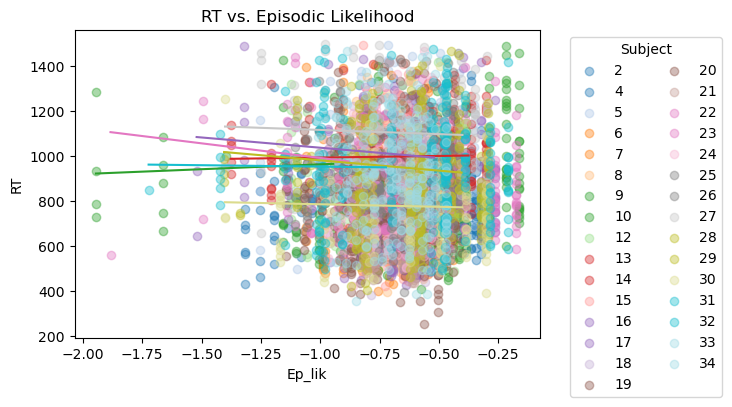

In [ ]:
from scipy.stats import linregress
rtdata = data[(~pd.isna(data.RT))&(~pd.isna(data.Ep_lik))]
subjects = rtdata.Sub.unique()
color_dict = {sub: plt.cm.tab20(np.linspace(0, 1, len(subjects))) [i] for i, sub in enumerate(subjects)}
plt.figure(figsize=(6,4))
for sub in subjects:
    sub_data = rtdata[rtdata.Sub == sub]
    plt.scatter(sub_data.RT, sub_data.Ep_lik, color=color_dict[sub], label=sub, alpha=0.4)
    slope, intercept, _,_,_ = linregress(sub_data.RT, sub_data.Ep_lik)
    x = np.arange( min(sub_data.RT), max(sub_data.RT))
    plt.plot(x, x*slope+intercept, color=color_dict[sub])
slope, intercept,_,_,_ = linregress(rtdata.RT, rtdata.Ep_lik)
x = np.arange( min(rtdata.RT), max(rtdata.RT))
plt.plot(x, x*slope+intercept, color='black', linewidth=4)
plt.xlabel("RT")
plt.ylabel("Ep_lik")
plt.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc="upper left", ncol=2)
plt.title('RT vs. Episodic Likelihood')
plt.show()

rtdata = data[(~pd.isna(data.RT))&(~pd.isna(data.Ep_lik))]
subjects = rtdata.Sub.unique()
color_dict = {sub: plt.cm.tab20(np.linspace(0, 1, len(subjects))) [i] for i, sub in enumerate(subjects)}
plt.figure(figsize=(6,4))
for sub in subjects:
    sub_data = rtdata[rtdata.Sub == sub]
    plt.scatter(sub_data.Ep_lik,sub_data.RT, color=color_dict[sub], label=sub, alpha=0.4)
    slope, intercept, _,_,_ = linregress(sub_data.Ep_lik, sub_data.RT)
    x = np.arange( min(sub_data.Ep_lik), max(sub_data.Ep_lik))
    plt.plot(x, x*slope+intercept, color=color_dict[sub])
slope, intercept,_,_,_ = linregress(rtdata.Ep_lik, rtdata.RT)
x = np.arange( min(sub_data.Ep_lik), max(sub_data.Ep_lik))
plt.plot(x, x*slope+intercept, color='black', linewidth=4)
plt.xlabel("Ep_lik")
plt.ylabel("RT")
plt.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc="upper left", ncol=2)
plt.title('RT vs. Episodic Likelihood')
plt.show()

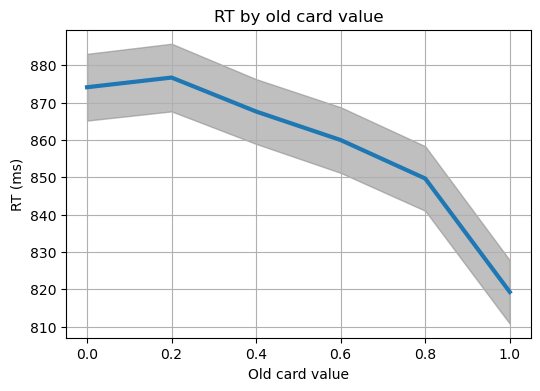

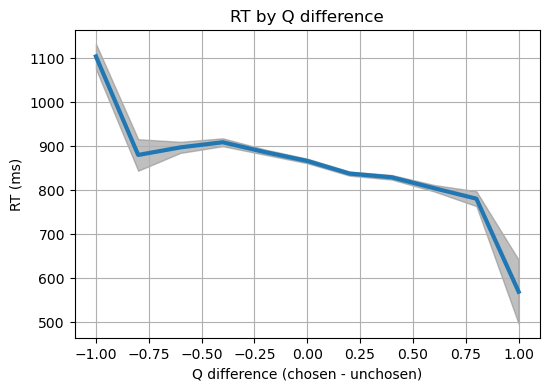

In [ ]:
# RT by old value
pf.simple_plot(data=data, x_var='ObjPP', y_var='RT', title='RT by old card value', xlabel='Old card value', ylabel='RT (ms)')

# RT by Q difference
def round_to_nearest_bin(x, bins):
    return bins[np.argmin(np.abs(bins - x))]
data['Q_diff_bin'] = data.Q_diff.apply(lambda x: round_to_nearest_bin(x, bins=np.linspace(-1,1,11)))
pf.simple_plot(data=data, x_var='Q_diff_bin', y_var='RT', title='RT by Q difference', xlabel='Q difference (chosen - unchosen)', ylabel='RT (ms)')

# # RT by ep_lik
# def round_to_nearest_bin(x, bins):
#     return bins[np.argmin(np.abs(bins - x))]
# data['ep_lik_bin'] = data.Ep_lik.apply(lambda x: round_to_nearest_bin(x, bins=np.linspace(-1,1,11)))
# pf.simple_plot(data=data, x_var='ep_lik_bin', y_var='RT', title='RT by episodic likelihood', xlabel='Episodic likelihood', ylabel='RT (ms)')

# pf.simple_plot(data=data, x_var='ep_lik_bin', y_var='ObjPP', title='Episodic likelihood by old value', xlabel='Episodic likelihood', ylabel='Old value')

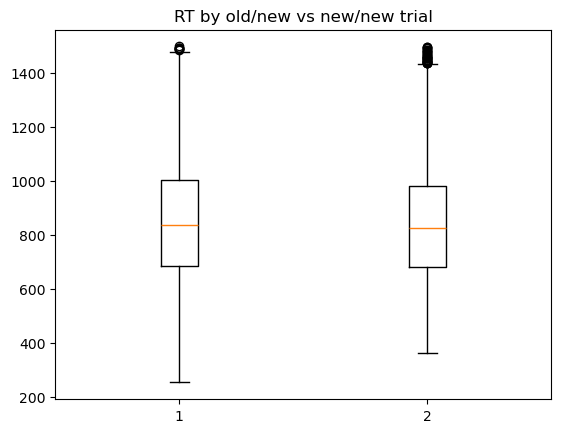

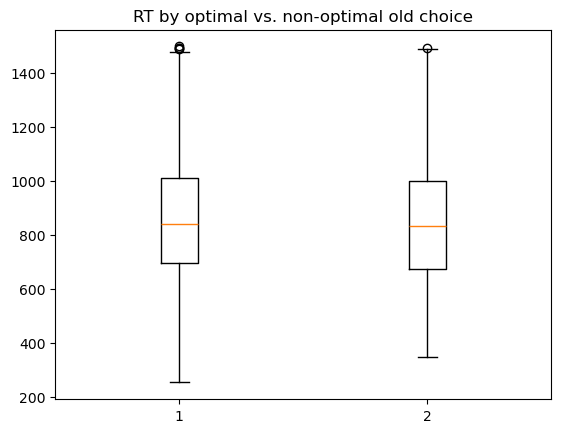

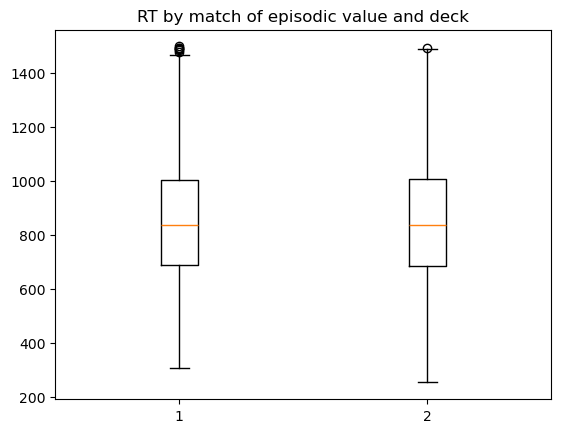

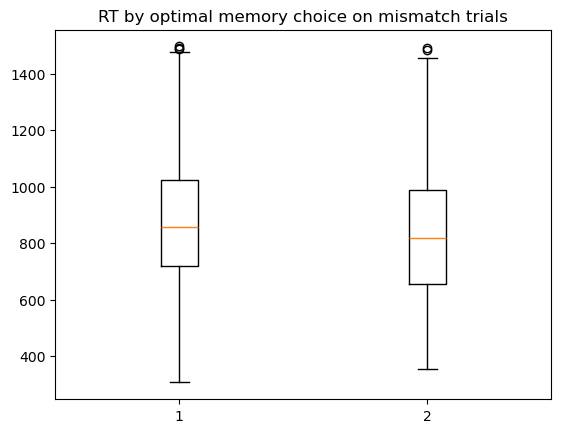

In [ ]:
# RT differences between key conditions?
plt.boxplot([ data[(data.OldT==1)&(~pd.isna(data.RT))].RT, data[(data.OldT==0)&(~pd.isna(data.RT))].RT ])
plt.title('RT by old/new vs new/new trial')
plt.show()

plt.boxplot([ data[(data.OptObj==1)&(~pd.isna(data.RT))].RT, data[(data.OptObj==0)&(~pd.isna(data.RT))].RT ])
plt.title('RT by optimal vs. non-optimal old choice')
plt.show()

plt.boxplot([ data[(data.ObjDeckMatch==1)&(~pd.isna(data.RT))].RT, data[(data.ObjDeckMatch==0)&(~pd.isna(data.RT))].RT ])
plt.title('RT by match of episodic value and deck')
plt.show()

plt.boxplot([ data[(data.OptObj==1)&(~pd.isna(data.RT))&(data.ObjDeckMatch==1)].RT, data[(data.OptObj==0)&(~pd.isna(data.RT))&(data.ObjDeckMatch==1)].RT ])
plt.title('RT by optimal memory choice on mismatch trials')
plt.show()

### Miscellaneous

does the old object being in the lucky deck affect its probability of being chosen?


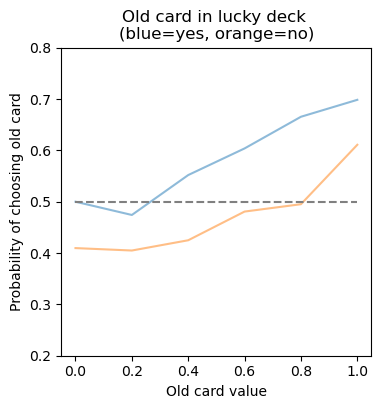

In [ ]:
x_var = 'OldObjLuckyDeck' # 0 for YES, 1 for NO
pf.overall_plot(data, x_var='ObjPP',y_var='OldObjC',grouping_var='OldObjLuckyDeck', mean=False,
                    xlabel='Old card value',ylabel='Probability of choosing old card',
                    ylim=(0.2,0.8), chance=0.5, title='Old card in lucky deck \n(blue=yes, orange=no)')

previous payment from the deck that the old card appears in

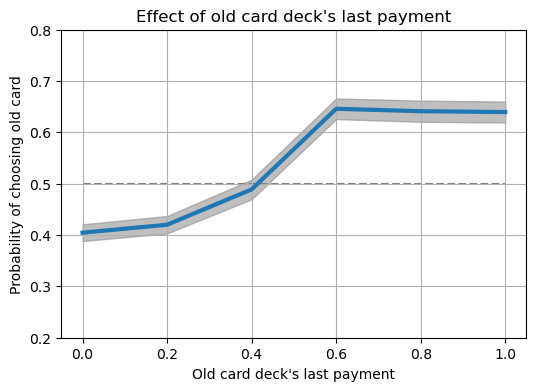

In [ ]:
pf.simple_plot(data, x_var='OldDeckPP',y_var='OldObjC',xlabel='Old card deck\'s last payment',
                ylabel='Probability of choosing old card',
               ylim=(0.2,0.8), chance=0.5, title='Effect of old card deck\'s last payment')

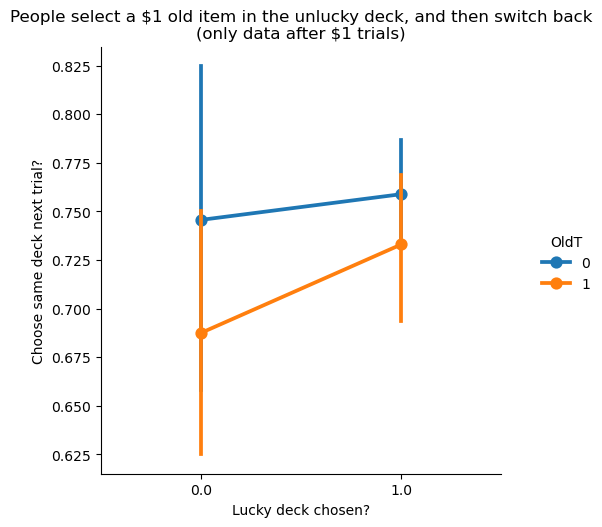

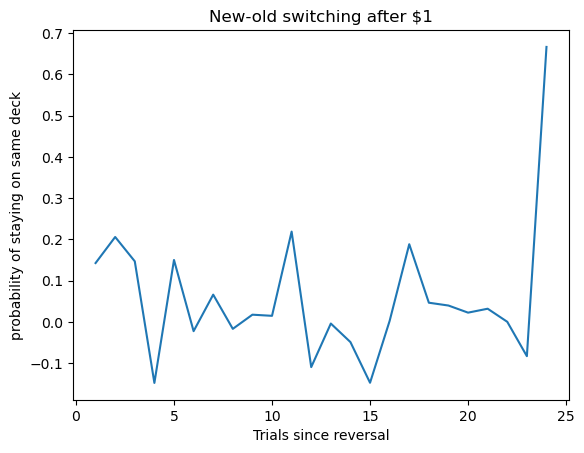

In [105]:
# when people get a $1, how likly are they to stay in the deck?

# pf.simple_plot(data[data.OldT.shift(1) == 0], x_var='PP', y_var='StayResp', title='How likely to stay in deck?',ylim=(0,1),
#                xlabel='Last trial outcome',ylabel='Probability of staying with same deck')

# why would they NOT choose the same deck after getting a 1?
# people select a $1 old item in the unlucky deck, and then switch back
data['next_trial_stay'] = data.StayResp.shift(-1)
sns.catplot(y='next_trial_stay', x='LuckyDeckC', hue='OldT', data=data[(data.Outcome==1)], kind='point')
plt.title('People select a $1 old item in the unlucky deck, and then switch back\n(only data after $1 trials)')
plt.xlabel('Lucky deck chosen?')
plt.ylabel('Choose same deck next trial?')
plt.show()

# this should increase over the reversal, right?
# compare difference in next_trial_stay between old and new at each reversal point
grouped = data[data.Outcome==1].groupby(['RevT','OldT']).mean()['next_trial_stay'].reset_index()
diffs = []
for RevT in grouped.RevT.unique():
    diffs.append(
                   grouped[(grouped.RevT == RevT)&(grouped.OldT==0)].next_trial_stay.iloc[0] - 
                   grouped[(grouped.RevT == RevT)&(grouped.OldT==1)].next_trial_stay.iloc[0]
    )
plt.plot(grouped.RevT.unique(), diffs)
plt.title('New-old switching after $1')
plt.xlabel('Trials since reversal')
plt.ylabel('probability of staying on same deck')
plt.show()

# if they get a $1 in the unlucky deck, what would it take for them to switch? look at next 5 trials
# data['one'] = data.Outcome==1
# data['one_1_ago'] = data.one.shift(1)
# data['one_2_ago'] = data.one.shift(2)
# data['one_3_ago'] = data.one.shift(3)
# data['one_4_ago'] = data.one.shift(4)
# data['one_5_ago'] = data.one.shift(5)

### Item effects

In [ ]:
# add object IDs
import ast
data.obj_ids = data.obj_ids.apply(ast.literal_eval)

# bin Q_red
data['Q_red_bin'] = pd.qcut(data.Q_red, q=6, duplicates='drop')
data['Q_red_bin'] = data['Q_red_bin'].apply(lambda x: x.mid)

# add object values
with open(LOCAL_PATH + 'Obj_value.txt', 'r') as f: # change the path as necessary
    lines = f.read().split('\n')


lines[0] = lines[0][lines[0].find('Obj'):] #Liam

obj_values = []
for line in lines:
  # get the value, turn it into a number
  third_thing = line[line.find(':')+1:].strip()
  if 'c' in third_thing:
    number = third_thing[:-1]
    value = float(number)/100
  else:
    value = float(third_thing)
  obj_values.append(value)

# obj_values is a list of object values, the 0th element in the list is the value of object 1

obj_tuples = []
for presented_objects in data.obj_ids:
  # each one of these is a tuple (left_obj_id, right_obj_id)
  left_id = presented_objects[0]
  right_id = presented_objects[1]
  left_value = obj_values[left_id-1]
  right_value = obj_values[right_id-1]

  obj_tuples.append((left_value, right_value))

data['obj_values'] = obj_tuples

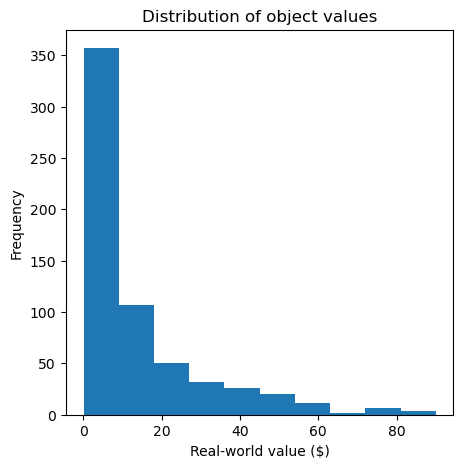

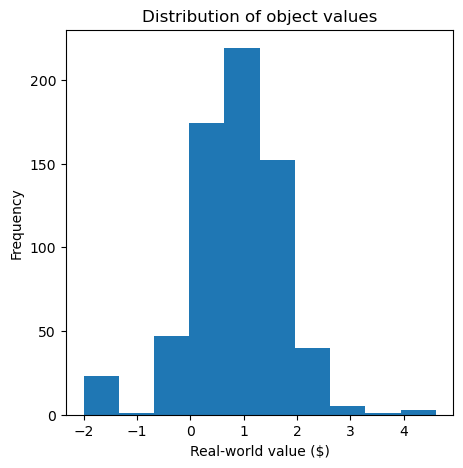

In [15]:
# distribution of object values
plt.figure(figsize=(5,5))
plt.title('Distribution of object values')
plt.xlabel('Real-world value ($)')
plt.ylabel('Frequency')
plt.hist(np.array(obj_values)[np.array(obj_values) < 100])
plt.show()

np.median(obj_values) # anything >= 7 is "high", anything less than 7 is low


# distribution of object values
plt.figure(figsize=(5,5))
plt.title('Distribution of object values')
plt.xlabel('Real-world value ($)')
plt.ylabel('Frequency')
plt.hist(np.log10(obj_values))
plt.show()

In [3]:
# add the following columns to dataframe: old card real value, new card real value, red card real value, blue card real value
data['old_card_real_value'] = np.nan
data['new_card_real_value'] = np.nan # only the value of the new card when it's an old trial (i.e., the alternative is old)
data['red_card_real_value'] = np.nan
data['blue_card_real_value'] = np.nan

for i in data.index:
  red_on_right = data.Resp[i] ==  data.DeckC[i]

  if red_on_right:
    data.loc[i, 'red_card_real_value'] = data.obj_values[i][1]
    data.loc[i, 'blue_card_real_value'] = data.obj_values[i][0]
  else: # red on left
    data.loc[i, 'red_card_real_value'] = data.obj_values[i][0]
    data.loc[i, 'blue_card_real_value'] = data.obj_values[i][1]

  if data.OldT[i] == 1:
    # data.OldDeck[i] will be 2 if old object in red deck, 1 if in blue deck
    old_on_right = (red_on_right and data.OldDeck[i]==2) or (not red_on_right and data.OldDeck[i]==1)

    if old_on_right:
      data.loc[i, 'old_card_real_value'] = data.obj_values[i][1]
      data.loc[i, 'new_card_real_value'] = data.obj_values[i][0]
    else:
      data.loc[i, 'old_card_real_value'] = data.obj_values[i][0]
      data.loc[i, 'new_card_real_value'] = data.obj_values[i][1]

In [ ]:
data['old_more_expensive'] = np.nan
for i in data.index:
  if data.OldT[i]==1:
    if data['old_card_real_value'][i] > data['new_card_real_value'][i]:
      data.loc[i, 'old_more_expensive'] = 1
    elif data['old_card_real_value'][i] < data['new_card_real_value'][i]:
      data.loc[i, 'old_more_expensive'] = 0


grouped_data = data[data.old_more_expensive == 1].groupby(['Sub','ObjPP'],observed=True)['OldObjC'].mean().reset_index()
old_higher = grouped_data.groupby('ObjPP')['OldObjC'].agg(['mean','sem']).reset_index()

grouped_data =  data[data.old_more_expensive == 0].groupby(['Sub','ObjPP'],observed=True)['OldObjC'].mean().reset_index()
old_lower = grouped_data.groupby('ObjPP')['OldObjC'].agg(['mean','sem']).reset_index()


plt.figure(figsize=(5,5))
plt.title('Episodic \n old split by more/less expensive than alternative')
# plot the dashed line for chance
plt.hlines(y=0.5, xmin=old_higher['ObjPP'].min(), xmax=old_higher['ObjPP'].max(), linestyle='--',color='gray',linewidth=3, label='chance')

# plot the data
plt.plot(old_higher['ObjPP'].values, old_higher['mean'], color='green', linewidth=5, label = 'old card > new card')
# plot the gray shading for +- SEM
plt.fill_between(old_higher['ObjPP'],old_higher['mean']-old_higher['sem'], old_higher['mean']+old_higher['sem'],alpha=0.5,color='green')

# plot the data
plt.plot(old_lower['ObjPP'].values, old_lower['mean'], color='orange', linewidth=5, label = 'old card < new card')
# plot the gray shading for +- SEM
plt.fill_between(old_lower['ObjPP'],old_lower['mean']-old_lower['sem'], old_lower['mean']+old_lower['sem'],alpha=0.5,color='orange')

plt.xlabel('Old object value')
plt.ylabel('% choose old')
plt.yticks([0,0.2,0.4,0.6,0.8, 1])
plt.legend(loc='lower right')
plt.ylim(0.2,0.8)
plt.tight_layout()
plt.show()

In [ ]:
data['old_above_7'] = np.nan
for i in data.index:
  if data.OldT[i]==1:
    if data['old_card_real_value'][i] > 7:
      data.loc[i, 'old_above_7'] = 1
    else:
      data.loc[i, 'old_above_7'] = 0

# These two lines were incorrect and causing issues. Remove them </3:
# old_high = data.old_above_7[i] = 1
# old_low = data.old_above_7[i] = 0

grouped_data2 = data[data.old_above_7 == 1].groupby(['Sub','ObjPP'],observed=True)['OldObjC'].mean().reset_index() # Use old_above_7
old_high = grouped_data2.groupby('ObjPP')['OldObjC'].agg(['mean','sem']).reset_index()

grouped_data2 =  data[data.old_above_7 == 0].groupby(['Sub','ObjPP'],observed=True)['OldObjC'].mean().reset_index() # Use old_above_7
old_low = grouped_data2.groupby('ObjPP')['OldObjC'].agg(['mean','sem']).reset_index()


plt.figure(figsize=(5,5))
plt.title('Episodic \n old split by >=< 7')
# plot the dashed line for chance
plt.hlines(y=0.5, xmin=old_high['ObjPP'].min(), xmax=old_high['ObjPP'].max(), linestyle='--',color='gray',linewidth=3, label='chance')

# plot the data
plt.plot(old_high['ObjPP'].values, old_high['mean'], color='pink', linewidth=5, label = '> 7')
# plot the gray shading for +- SEM
plt.fill_between(old_high['ObjPP'],old_high['mean']-old_high['sem'], old_high['mean']+old_high['sem'],alpha=0.5,color='pink')

# plot the data
plt.plot(old_low['ObjPP'].values, old_low['mean'], color='blue', linewidth=5, label = '< 7')
# plot the gray shading for +- SEM
plt.fill_between(old_low['ObjPP'],old_low['mean']-old_low['sem'], old_low['mean']+old_low['sem'],alpha=0.5,color='blue')

plt.xlabel('Old object value')
plt.ylabel('% choose old')
plt.yticks([0,0.2,0.4,0.6,0.8, 1])
plt.legend(loc='lower right')
plt.ylim(0.2,0.8)
plt.tight_layout()
plt.show()

In [ ]:
data['red_more_expensive'] = np.nan
for i in data.index:
  if data['red_card_real_value'][i] > data['blue_card_real_value'][i]:
    data.loc[i, 'red_more_expensive'] = 1
  elif data['blue_card_real_value'][i] < data['red_card_real_value'][i]:
    data.loc[i, 'red_more_expensive'] = 0


data_to_plot = data[data.OldT==0]

#### plotting:
# replace variables names AND *limit to only new trials* data[data.OldT==0]

data['red_more_expensive'] = np.nan
for i in data.index:
  if data.OldT[i]==0:
    if data['red_card_real_value'][i] > data['blue_card_real_value'][i]:
      data.loc[i, 'red_more_expensive'] = 1
    elif data['red_card_real_value'][i] < data['blue_card_real_value'][i]:
      data.loc[i, 'red_more_expensive'] = 0


grouped_data = data[data.red_more_expensive == 1].groupby(['Sub','Q_red_bin'],observed=True)['ChooseRed'].mean().reset_index()
red_higher = grouped_data.groupby('Q_red_bin')['ChooseRed'].agg(['mean','sem']).reset_index()

grouped_data =  data[data.red_more_expensive == 0].groupby(['Sub','Q_red_bin'],observed=True)['ChooseRed'].mean().reset_index()
red_lower = grouped_data.groupby('Q_red_bin')['ChooseRed'].agg(['mean','sem']).reset_index()


plt.figure(figsize=(5,5))
plt.title('Incremental \n new split by red more/less expensive than blue')
# plot the dashed line for chance
plt.hlines(y=0.5, xmin=red_higher['Q_red_bin'].min(), xmax=red_higher['Q_red_bin'].max(), linestyle='--',color='gray',linewidth=3, label='chance')

# plot the data
plt.plot(red_higher['Q_red_bin'].values, red_higher['mean'], color='red', linewidth=5, label = 'red card > blue card')
# plot the gray shading for +- SEM
plt.fill_between(red_higher['Q_red_bin'],red_higher['mean']-red_higher['sem'], red_higher['mean']+red_higher['sem'],alpha=0.5,color='red')

# plot the data
plt.plot(red_lower['Q_red_bin'].values, red_lower['mean'], color='blue', linewidth=5, label = 'red card < blue card')
# plot the gray shading for +- SEM
plt.fill_between(red_lower['Q_red_bin'],red_lower['mean']-red_lower['sem'], red_lower['mean']+red_lower['sem'],alpha=0.5,color='blue')

plt.xlabel('Red object value')
plt.ylabel('% choose old')
plt.yticks([0,0.2,0.4,0.6,0.8, 1])
plt.legend(loc='lower right')
plt.ylim(0.2,0.8)
plt.tight_layout()
plt.show()

In [ ]:
data['red_more_expensive'] = np.nan
for i in data.index:
  if data['red_card_real_value'][i] > data['blue_card_real_value'][i]:
    data.loc[i, 'red_more_expensive'] = 1
  elif data['blue_card_real_value'][i] < data['red_card_real_value'][i]:
    data.loc[i, 'red_more_expensive'] = 0


data_to_plot = data

# same thing as new trials more/less but DONT limit to only new trials
# you can use the same 'red_more_expensive' column without re-computing it. just copy the plotting code and take out the mask for only new trials

data['red_more_expensive'] = np.nan
for i in data.index:
  if data['red_card_real_value'][i] > data['blue_card_real_value'][i]:
    data.loc[i, 'red_more_expensive'] = 1
  elif data['red_card_real_value'][i] < data['blue_card_real_value'][i]:
    data.loc[i, 'red_more_expensive'] = 0


grouped_data = data[data.red_more_expensive == 1].groupby(['Sub','Q_red_bin'],observed=True)['ChooseRed'].mean().reset_index()
red_higher = grouped_data.groupby('Q_red_bin')['ChooseRed'].agg(['mean','sem']).reset_index()

grouped_data =  data[data.red_more_expensive == 0].groupby(['Sub','Q_red_bin'],observed=True)['ChooseRed'].mean().reset_index()
red_lower = grouped_data.groupby('Q_red_bin')['ChooseRed'].agg(['mean','sem']).reset_index()


plt.figure(figsize=(5,5))
plt.title('Incremental \n All split by red more/less expensive than blue')
# plot the dashed line for chance
plt.hlines(y=0.5, xmin=red_higher['Q_red_bin'].min(), xmax=red_higher['Q_red_bin'].max(), linestyle='--',color='gray',linewidth=3, label='chance')

# plot the data
plt.plot(red_higher['Q_red_bin'].values, red_higher['mean'], color='red', linewidth=5, label = 'red card > blue card')
# plot the gray shading for +- SEM
plt.fill_between(red_higher['Q_red_bin'],red_higher['mean']-red_higher['sem'], red_higher['mean']+red_higher['sem'],alpha=0.5,color='red')

# plot the data
plt.plot(red_lower['Q_red_bin'].values, red_lower['mean'], color='blue', linewidth=5, label = 'red card < blue card')
# plot the gray shading for +- SEM
plt.fill_between(red_lower['Q_red_bin'],red_lower['mean']-red_lower['sem'], red_lower['mean']+red_lower['sem'],alpha=0.5,color='blue')

plt.xlabel('Red object value')
plt.ylabel('% choose old')
plt.yticks([0,0.2,0.4,0.6,0.8, 1])
plt.legend(loc='lower right')
plt.ylim(0.2,0.8)
plt.tight_layout()
plt.show()

In [17]:
from pymer4.models import Lmer

model = Lmer("ChooseRed ~ OldValRed + Q_red + log(red_card_real_value) + (1| Sub)", data, family='binomial')
model.fit()
print(model.summary())

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseRed~OldValRed+Q_red+log(red_card_real_value)+(1|Sub)

Family: binomial	 Inference: parametric

Number of observations: 9239	 Groups: {'Sub': 31.0}

Log-likelihood: -5713.870 	 AIC: 11437.740

Random effects:

            Name    Var    Std
Sub  (Intercept)  0.072  0.268

No random effect correlations specified

Fixed effects:

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseRed~OldValRed+Q_red+log(red_card_real_value)+(1|Sub)

Family: binomial	 Inference: parametric

Number of observations: 9239	 Groups: {'Sub': 31.0}

Log-likelihood: -5713.870 	 AIC: 11437.740

Random effects:

            Name    Var    Std


/Users/chrisiyer/miniconda3/envs/hbi/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [10]:
# COMBINED DATA WITH JONATHAN'S TASK
from pymer4.models import Lmer
import pandas as pd
combined_data = pd.read_csv(LOCAL_PATH + 'combined_data.csv')
combined_data['value_diff'] = np.log(combined_data.red_card_real_value) - np.log(combined_data.blue_card_real_value)
model = Lmer("ChooseRed ~ OldValRed + LuckRed + value_diff + (1| Sub)", 
             combined_data, family='binomial')
model.fit()
print(model.summary())

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseRed~OldValRed+LuckRed+value_diff+(1|Sub)

Family: binomial	 Inference: parametric

Number of observations: 89800	 Groups: {'Sub': 254.0}

Log-likelihood: -36390.749 	 AIC: 72791.497

Random effects:

            Name    Var    Std
Sub  (Intercept)  0.099  0.315

No random effect correlations specified

Fixed effects:

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: ChooseRed~OldValRed+LuckRed+value_diff+(1|Sub)

Family: binomial	 Inference: parametric

Number of observations: 89800	 Groups: {'Sub': 254.0}

Log-likelihood: -36390.749 	 AIC: 72791.497

Random effects:

            Name    Var    Std
Sub  (Intercept)  

/Users/chrisiyer/miniconda3/envs/hbi/lib/python3.9/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


### memorability

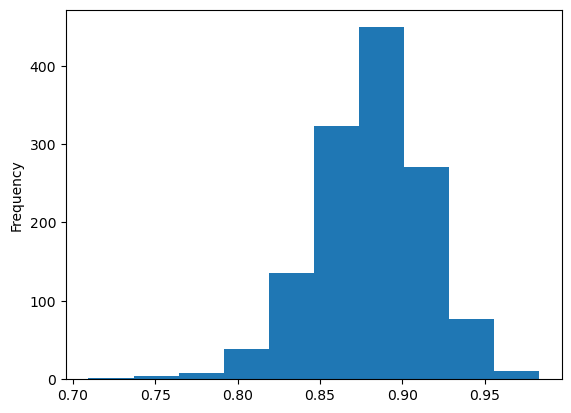

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
obj = pd.read_csv('/Users/chrisiyer/_Current/lab/code/hybrid_rl/fmri_analysis/data/objects.csv')
obj.memscore.plot(kind='hist')
plt.show()

# Issues

TRIAL TIMING
The naming of the timing data in the matlab outputs is a bit misleading, and led to the Choice EVs being constructed wrong.
- startTrial is actually the start of the jittered ITI
- startChoice is the stimulus onset, not the time of choice
- startDelay is the time of the response, then lasting 3s until FB (or, on no-response trials, lasting 0s). This is when the box is shown around the chosen card.
- startFB is the feedback phase, always ~1.5s
- startISI is just a fraction of a second before the next startTrial, but is technically the start of the jittered ITI.

in `make_EV.m`, the stimulus onset times were taken as 'startTrial' and the response times as 'startChoice', when in reality the stimulus onset times are startChoice and the response time is startDelay.

So, we had to re-create the choice EVs.

In [ ]:
# load matlab outputs
subdir = '02_output'
# sub = subdir[0:2]
subdirpath = os.path.join(SERVER_PATH, 'behavior', subdir)
run = '1'

matfile = scipy.io.loadmat(subdirpath + f'/Performance_{run}.mat') # these files actually contain all data from this run and preceding, so we have to filter
run_mask = matfile['Performance']['cond'][0,0]['Run'][0,0][0].astype(str) == run # current run
valid_mask = ~np.isnan( matfile['Performance']['choose'][0, 0]['resp'][0,0][0] ) # non-nan responses

actual_rts = matfile['Performance']['choose'][0,0]['RT'][0,0][0][run_mask] / 1000 # ms to s
startChoice = matfile['Performance']['time'][0,0]['startChoice'][0,0][0][run_mask] # time of RT
startDelay = matfile['Performance']['time'][0,0]['startDelay'][0,0][0][run_mask] # time of RT
startISI = matfile['Performance']['time'][0,0]['startISI'][0,0][0][run_mask]
startTrial = matfile['Performance']['time'][0,0]['startTrial'][0,0][0][run_mask]
startFB= matfile['Performance']['time'][0,0]['startFB'][0,0][0][run_mask]

print('startTrial to startChoice: ', (startChoice-startTrial)[0:6])
print('startChoice to startDelay: ', (startDelay-startChoice)[0:6])
print('RT (should match above): ', actual_rts[0:6])
print('startDelay to startFB: ', (startFB-startDelay)[0:6])
print('startFB to startISI: ', (startISI-startFB)[0:6])

startTrial to startChoice:  [1.87785247 4.26363835 2.43419048 3.74383787 3.15629206 2.6019752 ]
startChoice to startDelay:  [0.68817    0.77233337 0.47027753 0.82252273 0.60429546 0.70516846]
RT (should match above):  [0.68299483 0.7522088  0.45936071 0.81789436 0.60051739 0.69173266]
startDelay to startFB:  [3.00542954 3.00515326 3.00529576 3.00553087 3.00529617 3.00544316]
startFB to startISI:  [1.51105874 1.51121397 1.51095217 1.51106817 1.51122888 1.51106905]


In [ ]:
# is there a consistent latency between the expected event time and the actual?
# No. Feedback was ~0.011s longer than expected, delay was 0.005s longer than expected

fb_start_times = matfile['Performance']['time'][0,0]['startFB'][0,0][0][run_mask]
fb_end_times = matfile['Performance']['time'][0,0]['startISI'][0,0][0][run_mask]
delay_start = matfile['Performance']['time'][0,0]['startDelay'][0,0][0][run_mask]
fb_durations = fb_end_times -  fb_start_times
delay_durations = fb_start_times-delay_start

print('Feedback supposed to be 1.5s, actually this much longer: \n', fb_durations - 1.5)
print('\nDelay supposed to be 3s, actually this much longer:\n', delay_durations -3)


Feedback supposed to be 1.5s, actually this much longer: 
 [0.01105874 0.01121397 0.01095217 0.01106817 0.01122888 0.01106905
 0.01104059 0.01091926 0.01106467 0.01091439 0.01107652 0.01117688
 0.01102164 0.01094096 0.01086412 0.0111901  0.01104388 0.01104158
 0.0111588  0.01104518 0.01102447 0.01106016 0.01118266 0.0107865
 0.01106696 0.01092181 0.01101263 0.01122223 0.01118689 0.0111139
 0.01087194 0.01101151 0.01093037 0.01106537 0.01093607 0.0110397
 0.01109426 0.01104871 0.01122648 0.01109494 0.01120172 0.01105079
 0.01094379 0.01120187 0.01105624 0.01107762 0.01119361 0.01094083
 0.01104829 0.01105189 0.01124198 0.01107994 0.01111225 0.01119772
 0.01102791 0.01117684 0.01106646 0.01102856 0.01106728 0.01105534]

Delay supposed to be 3s, actually this much longer:
 [ 0.00542954  0.00515326  0.00529576  0.00553087  0.00529617  0.00544316
  0.00545512  0.00544907  0.0053172   0.00531654  0.00517929  0.00534369
  0.00535903  0.00544458  0.00536926  0.00519608  0.0052977   0.005341
  

In [ ]:
# there are 59 trials with episodic likelihood but its not an old trial?
# all subject 13
data[data.Ep_lik.notna() & (data.OldT==0)]

Sub  Run  Trial  OldT  Delay  LuckyDeck  ObjPP  OldObjLuckyDeck  \
2759   13    2     61     0    NaN          2    NaN              NaN   
2761   13    2     63     0    NaN          2    NaN              NaN   
2763   13    2     65     0    NaN          2    NaN              NaN   
2768   13    2     70     0    NaN          2    NaN              NaN   
2770   13    2     72     0    NaN          2    NaN              NaN   
2774   13    2     76     0    NaN          1    NaN              NaN   
2780   13    2     82     0    NaN          1    NaN              NaN   
2784   13    2     86     0    NaN          1    NaN              NaN   
2787   13    2     89     0    NaN          1    NaN              NaN   
2790   13    2     92     0    NaN          2    NaN              NaN   
2792   13    2     94     0    NaN          2    NaN              NaN   
2801   13    2    103     0    NaN          2    NaN              NaN   
2805   13    2    107     0    NaN          2    NaN              NaN   
2808   13    2    110     0    NaN          1    NaN              NaN   
2810   13    2    112     0    NaN          1    NaN              NaN   
2812   13    2    114     0    NaN          1    NaN              NaN   
2815   13    2    117     0    NaN          1    NaN              NaN   
2822   13    3    124     0    NaN          2    NaN              NaN   
2825   13    3    127     0    NaN          2    NaN              NaN   
2830   13    3    132     0    NaN          2    NaN              NaN   
2834   13    3    136     0    NaN          2    NaN              NaN   
2836   13    3    138     0    NaN          2    NaN              NaN   
2842   13    3    144     0    NaN          1    NaN              NaN   
2852   13    3    154     0    NaN          1    NaN              NaN   
2855   13    3    157     0    NaN          1    NaN              NaN   
2858   13    3    160     0    NaN          1    NaN              NaN   
2861   13    3    163     0    NaN          2    NaN              NaN   
2870   13    3    172     0    NaN          2    NaN              NaN   
2882   13    4    184     0    NaN          1    NaN              NaN   
2885   13    4    187     0    NaN          1    NaN              NaN   
2889   13    4    191     0    NaN          1    NaN              NaN   
2896   13    4    198     0    NaN          1    NaN              NaN   
2905   13    4    207     0    NaN          2    NaN              NaN   
2912   13    4    214     0    NaN          2    NaN              NaN   
2915   13    4    217     0    NaN          2    NaN              NaN   
2920   13    4    222     0    NaN          1    NaN              NaN   
2923   13    4    225     0    NaN          1    NaN              NaN   
2928   13    4    230     0    NaN          1    NaN              NaN   
2932   13    4    234     0    NaN          1    NaN              NaN   
2937   13    4    239     0    NaN          2    NaN              NaN   
2942   13    5    244     0    NaN          2    NaN              NaN   
2946   13    5    248     0    NaN          2    NaN              NaN   
2949   13    5    251     0    NaN          2    NaN              NaN   
2953   13    5    255     0    NaN          1    NaN              NaN   
2955   13    5    257     0    NaN          1    NaN              NaN   
2960   13    5    262     0    NaN          1    NaN              NaN   
2963   13    5    265     0    NaN          1    NaN              NaN   
2969   13    5    271     0    NaN          1    NaN              NaN   
2973   13    5    275     0    NaN          2    NaN              NaN   
2977   13    5    279     0    NaN          2    NaN              NaN   
2979   13    5    281     0    NaN          2    NaN              NaN   
2981   13    5    283     0    NaN          2    NaN              NaN   
2983   13    5    285     0    NaN          2    NaN              NaN   
2986   13    5    288     0    NaN          2    NaN            